<a href="https://colab.research.google.com/github/LaSpi21/BioInfoAv2020/blob/main/Trabajo_Practico_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> <h1>Trabajo Práctico 4</h1> </center>
<center> <h2>Similitud de compuestos y clusterización</h2> </center>

---
# Preparación del notebook

En la celda que se encuentra a continuación vamos a importar todas las librerías que se van a usar.

❗ Para correr la celda podes apretar el boton "Run" o usar el comando "Ctrl + Enter"

👇

In [ ]:
# Instalar las librerias
!pip install pandas rdkit tqdm useful_rdkit_utils seaborn scikit-posthocs chembl_downloader chembl_webresource_client  pubchempy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 53.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.9 MB/s eta 0:00:00
  Created wheel for useful_rdkit_utils: filename=useful_rdkit_utils-0.2.7-py3-none-any.whl size=18384 sha256=59fc1b1e4c8b4ca5edb86742e3f428d5f35af17354617fc907a924d01ecc59af
  Stored in directory: /root/.cache/pip/wheels/66/d2/4c/94e82b5623723fcc89b502c6d69c0d7e2ae6075fa2928e26e9
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=2d4d17db800ad2a0a5ea7a2537372c2296a53413d926863a1aca279f04cfc316


In [ ]:
# Importar las librerias con las que vamos a trabajar en este práctico
# Importar libreria para guardar archivos
import os

# Importar libreria para guardar trabajar con tablas
import pandas as pd
import numpy as np

# Importar las librerias de RDKit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Fingerprints import FingerprintMols

# Importar las librerias para graficar
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import seaborn as sns

# Importar las funciones de 'scipy'
from scipy.cluster.hierarchy import dendrogram, linkage, is_valid_linkage, cut_tree

# Importar las funciones de 'sklearn'
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# Importar libreria de ChEMBL
from chembl_webresource_client.new_client import new_client

# Importar libreria de PubChem
import pubchempy as pcp

# Importar libreria para ver una barra con el progreso de cada comando
from tqdm.auto import tqdm
tqdm.pandas()

# Importar el módulo de advertencias
import warnings

# Importar el módulo sys
import sys
np.set_printoptions(threshold=sys.maxsize)


---

En este práctico vamos a estar trabajando con los comandos de RDKit para evaluar la similitud química de una lista de moléculas y agruparlas.

La evaluación de similitud y la clusterización de moléculas son técnicas fundamentales en la química computacional y la ciencia de datos aplicada a la química. Estas técnicas se utilizan para analizar y comparar grandes conjuntos de moléculas, lo que proporciona información valiosa para la investigación farmacéutica, el descubrimiento de fármacos, la química de materiales y otros campos relacionados.

La evaluación de similitud de moléculas se refiere al cálculo de la similitud o la distancia entre dos o más moléculas. Esta similitud se basa en diversas características moleculares, como la estructura, la conectividad atómica o las propiedades químicas.

La evaluación de similitud de moléculas se refiere al cálculo de la similitud o la distancia entre dos o más moléculas. Esta similitud se basa en diversas características moleculares, como la estructura, la conectividad atómica o las propiedades químicas.

A lo largo de este práctico vamos a explorar diferentes metodologías para llevar adelante estos análisis

# Obtención de los datos

Vamos a trabajar con moléculas del Bioensayo de ChEMBL [CHEMBL674637](https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL674637/). En ChEMBL además de haber compuestos bioactivos, están curados e integrados los datos y referencias de como se demostró y midió la actividad de los compuestos.

En este caso, los compuestos fueron ensayados por este criterio: *Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase* [Sun L, et al. (2002). Bioorg Med Chem Lett. 2002 12(16):2153-7.](https://pmid.us/12127526/)

A continuación encontrarán los comandos para obtener los datos de ChEMBL:

ID                                             smiles  \
0    0  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   
1    1  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
2    2  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...   
3    3  CCN(CC)CC(O)CNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc...   
4    4  O=C1Nc2ncnc(Nc3ccc(F)c(Cl)c3)c2/C1=C/c1ccc(C(=...   
5    5  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
6    6  CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ncnc(...   
7    7  Cc1cc(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c32)...   
8    8  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
9    9  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncn...   
10  10  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
11  11  CCN1CCN(C(=O)c2cc(C)c(/C=C3\C(=O)Nc4ncnc(Nc5cc...   
12  12  Cc1cc(C(=O)O)[nH]c1/C=C1\C(=O)Nc2ncnc(Nc3ccc(F...   
13  13  Cc1cc(CCC(=O)O)[nH]c1/C=C1\C(=O)Nc2ncnc(Nc3ccc...   
14  14  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
15  15  Cc1cc(C(=O)N2CCN(C)CC2)[nH]c1/C=C1\C(=O)Nc2ncn...   
16  16  C#Cc1cccc(Nc2ncnc3c2/C(=C/c2[nH]c(C(=O)NCCN4CC...   
17  17  CCN(CC)CCNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4...   
18  18  Cc1c(C(=O)N2CCN(C)CC2)c[nH]c1/C=C1\C(=O)Nc2ncn...   
19  19  Cc1cc(C(=O)N2CC(C)NC(C)C2)[nH]c1/C=C1\C(=O)Nc2...   
20  20  Cc1cc(C)c(/C=C2\C(=O)N(C)c3ncnc(Nc4ccc(F)c(Cl)...   
21  21    O=C1Nc2ncnc(Nc3ccc(F)c(Cl)c3)c2/C1=C/c1ccc[nH]1   
22  22  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncn...   
23  23  Cc1[nH]c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c...   
24  24  CCN(CC)CCNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4...   

                                               ROMol  
0   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5b60>  
1   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5d20>  
2   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5f50>  
3   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5d90>  
4   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5fc0>  
5   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6030>  
6   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad60a0>  
7   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6110>  
8   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6180>  
9   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad61f0>  
10  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6260>  
11  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad62d0>  
12  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6340>  
13  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad63b0>  
14  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6420>  
15  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6490>  
16  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6500>  
17  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6570>  
18  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad65e0>  
19  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6650>  
20  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad66c0>  
21  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6730>  
22  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad67a0>  
23  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6810>  
24  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6880>
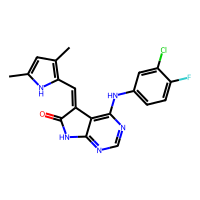
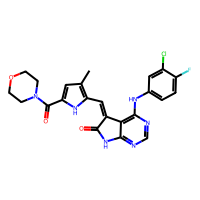
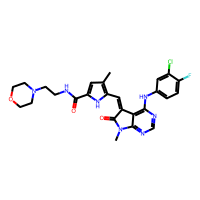
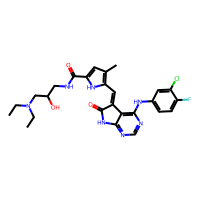
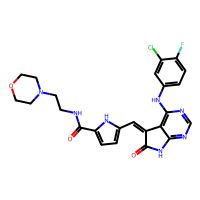
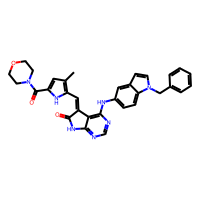
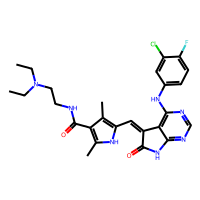
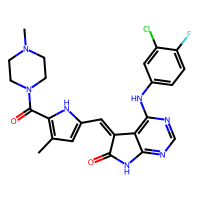
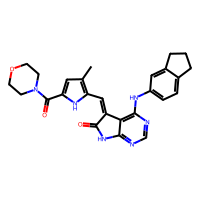
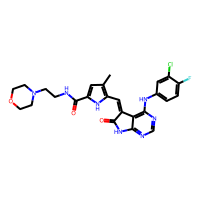
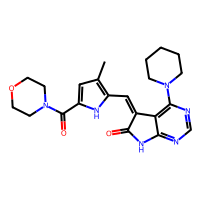
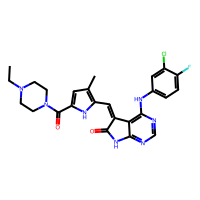
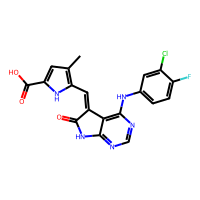
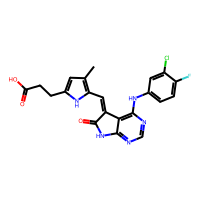
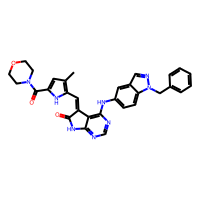
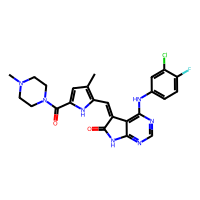
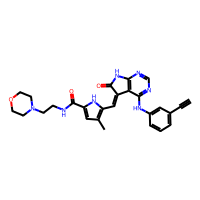
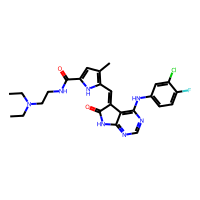
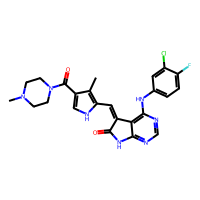
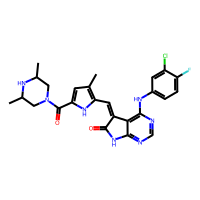
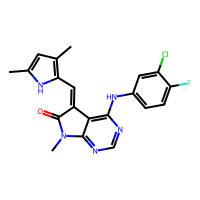
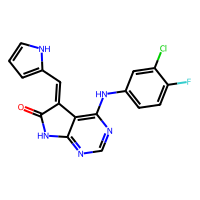
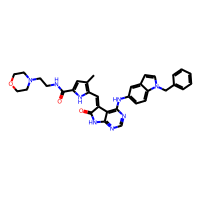
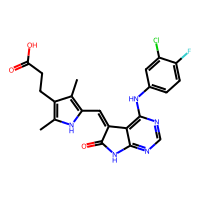
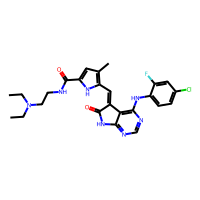

In [ ]:
# Filtrar la actividad del nuevo cliente por el identificador de ensayo "CHEMBL674637" y seleccionar solo las columnas 'molecule_chembl_id' y 'canonical_smiles'
data = new_client.activity.filter(assay_chembl_id="CHEMBL674637").only(['molecule_chembl_id', 'canonical_smiles'])

#Armar una tabla con los datos
data_frame = pd.DataFrame.from_dict(data)

#Seleccionar la columna de los smiles
smiles = data_frame['canonical_smiles']

#Generar una tabla que contenga los smiles del ensayo
tabla_CHEMBL674637 = pd.DataFrame()
IDs = range(0,25)
tabla_CHEMBL674637["ID"] = IDs
tabla_CHEMBL674637['smiles'] = smiles

# Agregar una columna de moléculas a la tabla 'tabla_CHEMBL674637' utilizando la columna 'smiles'
PandasTools.AddMoleculeColumnToFrame(tabla_CHEMBL674637, smilesCol='smiles')

tabla_CHEMBL674637


---
# Parte 1: Clusterización por Fingerprints



## Cálculo de similitud de moléculas

El RDKit tiene una variedad de funciones integradas para generar fingerprints moleculares y usarlas para calcular la similitud molecular.

Si te interesa este tema podés leer más en este [link](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf)

Para poder comparar las moléculas y medir su similitud, primero tenemos que generear el fingerprint molecular de cada una usando la función llamada `FingerprintMol()`. En RDKit esta y otras funciones están agrupadas dentro del módulo [FingerprintMols](https://www.rdkit.org/docs/source/rdkit.Chem.Fingerprints.FingerprintMols.htm).

👇

In [ ]:
# Crear una lista de huellas moleculares para cada molécula en la columna 'ROMol'
fps = [FingerprintMols.FingerprintMol(mol) for mol in tabla_CHEMBL674637['ROMol']]

💭 ¿Que obtuvimos luego de ejecutar ese comando?

❗ Escribí la variable que generamos en la celda que se encuentra debajo

👇

In [ ]:
fps

Vamos a verificar que RDKit pudo calcular el fingerprint para todas las moléculas

👇

In [ ]:
# Obtener la cantidad de filas en la tabla 'tabla_CHEMBL674637'
print(len(tabla_CHEMBL674637))

# Obtener la cantidad de huellas moleculares en la lista 'fps'
print(len(fps))

25
25


¿Que tipo de objeto es una huella molecular?

In [ ]:
type(fps[0])

rdkit.DataStructs.cDataStructs.ExplicitBitVect

Los `Bitvectors` son contenedores para almacenar de manera eficiente un número determinado de valores binarios, como fingerprints.

RDKit incluye `ExplicitBitVect` como `Bitvector` para almacenar los valores internamente de este tipo de datos

Asi se ve el `ExplicitBitVect` del fingerprint de una molécula:

In [ ]:
# Crea un array llamado 'vector' a partir del primer elemento de la lista 'fps'
vector = np.array(fps[0])
print(vector)

[1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1
 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0
 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1
 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0
 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0
 0 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 1 1 1
 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1
 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1
 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1
 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1
 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 0
 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1
 1 1 1 1 0 1 1 1 1 0 0 1 

Ahora que tenemos los fingerprints podemos empezar a comparar moléculas.
Podemos hacerlo usando la función llamada `FingerprintSimilarity()`

Vamos a comparar la similitud entre molécula 1 y la 2
👇

0.8888888888888888


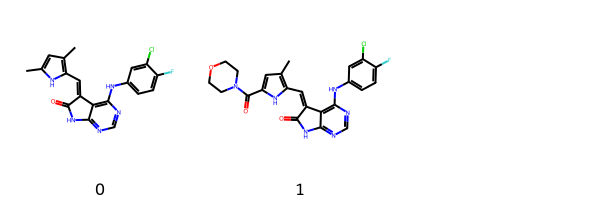

In [ ]:
# Imprimir la similitud de fingerprint moleculares entre fps[0] y fps[1]
print(DataStructs.FingerprintSimilarity(fps[0], fps[1]))

# Mostrar una imagen de cuadrícula con las estructuras moleculares en las posiciones 0 y 1 de la columna 'ROMol'
Draw.MolsToGridImage([tabla_CHEMBL674637['ROMol'][0], tabla_CHEMBL674637['ROMol'][1]], legends=['0', '1'])

La función `FingerprintSimilarity()` arroja valores entre 0 y 1, siendo 1 el que indica cuando dos moléculas son idénticas.

El valor obtenido en este caso nos dice que estás dos moléculas tienen una similitud de 0.89 (89%). O dicho de otra forma, están a una distancia de Tanimoto de 0.89. La distancia o métrica de Tanimoto va de 0 (no hay similitud) a 1 (similitud máxima).

Probemos con dos moléculas más parecidas

👇

0.9197127937336814


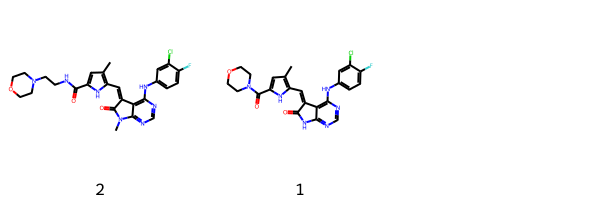

In [ ]:
# Imprimir la similitud de huellas moleculares entre fps[15] y fps[1]
print(DataStructs.FingerprintSimilarity(fps[2], fps[1]))

# Mostrar una imagen de cuadrícula con las estructuras moleculares en las posiciones 15 y 1 de la columna 'ROMol'
Draw.MolsToGridImage([tabla_CHEMBL674637['ROMol'][2], tabla_CHEMBL674637['ROMol'][1]], legends=['2', '1'])

En este caso podemos ver, en base a la estructura y al valor obtenido, que la molécula 1 es más similiar a la 2 que a la 0

💭 ¿Podés encontrar otra molécula con mayor similitud a la molécula 1?

❗ Escribí el comando en la celda que se encuentra debajo

Pista: Pueden recorrer toda la tabla de moléculas usando un `for`

👇

In [ ]:
dict_tanimoto = {}
for fp in range(0,len(fps)):
  dict_tanimoto[DataStructs.FingerprintSimilarity(fps[fp], fps[1])] = fp

keys = list(dict_tanimoto.keys())
keys.sort(reverse=True)
sorted_dict = {i: dict_tanimoto[i] for i in keys}

print(sorted_dict, end="\n")

{1.0: 1, 0.9678742310321258: 15, 0.9652351738241309: 11, 0.9629375428963624: 9, 0.9587061252580867: 17, 0.9538043478260869: 3, 0.9421157684630739: 19, 0.9272363150867824: 8, 0.9206137424949966: 7, 0.9197127937336814: 2, 0.9183253260123542: 4, 0.9169457468184863: 24, 0.9085406859448554: 16, 0.8915971776779987: 5, 0.8888888888888888: 0, 0.887762001352265: 12, 0.8764115432873275: 14, 0.869116698903933: 6, 0.867518493611298: 13, 0.8657760814249363: 22, 0.8631578947368421: 23, 0.8605263157894737: 20, 0.8549323017408124: 18, 0.8410290237467019: 10, 0.8236111111111111: 21}


Como vimos en prácticos anteriores, tenemos mucha información y resulta dificil sacar conclusiones a partir de los datos.
Vamos a ver como podemos generar gráficos con estos datos para poder sacar inferencias.


La métrica de similitud predeterminada utilizada por rdkit.DataStructs.FingerprintSimilarity() es la similitud de Tanimoto. Se pueden usar diferentes métricas de similitud:

In [ ]:
DataStructs.FingerprintSimilarity(fps[0],fps[1], metric=DataStructs.DiceSimilarity)

0.9411764705882353


Las métricas de similitud disponibles son vairas, e incluyen Tanimoto, Dice, Cosine, Sokal, Russel, Kulczynski, McConnaughey y Tversky.

Hay mucha literatura sobre los pros y contras de cada una de estas métricas, los sesgos y/o limitaciones de cada una, etc. Les dejamos algunos links de estudio:

 - [Horvath, Marcou, & Varnek (2013).](https://doi:10.1021/ci400106g)
 - [O'Hagan & Kell (2016).](https://doi.org/10.3389%2Ffphar.2016.00266)
 - [Swamidass & Baldi (2007).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2527184/)
 - [Baldi & Nasr (2010).](https://doi.org/10.1021/ci100010v)

## Agrupación de moléculas en base a su similitud

La agrupación o `clustering` de moléculas en base a su similitud es una técnica ampliamente utilizada en química y ciencias de la vida para organizar y analizar grandes conjuntos de moléculas.

La similitud molecular se puede medir utilizando diversos algoritmos y métodos, siendo uno de los más comunes el cálculo de similitud mediante fingerprints.

Primero vamos a generar una tabla con la comparación de similitud de todas las moléculas.

👇

In [ ]:
# Configurar el manejo de advertencias
warnings.filterwarnings('ignore')

# Obtener el tamaño de la tabla 'tabla_CHEMBL674637'
size = len(tabla_CHEMBL674637)

# Crear un arreglo vacío para almacenar la matriz de similitud
hmap = np.empty(shape=(size, size))

# Crear un DataFrame vacío
table = pd.DataFrame()

# Iterar sobre las filas de la tabla
for i in range(len(tabla_CHEMBL674637)):
    # Iterar sobre las columnas de la tabla
    for j in range(len(tabla_CHEMBL674637)):
        # Calcular la similitud de huellas moleculares entre fps[i] y fps[j]
        similarity = DataStructs.FingerprintSimilarity(fps[i], fps[j])
        # Almacenar la similitud en la matriz hmap
        hmap[i, j] = similarity
        # Agregar la similitud al DataFrame 'table' con los índices correspondientes
        table.loc[tabla_CHEMBL674637['ID'][i], tabla_CHEMBL674637['ID'][j]] = similarity


Luego de ejecutar este comando obtuvimos una tabla con los valores de similitud entre todos los pares posibles de moléculas

👇

In [ ]:
# Imprimir el contenido del DataFrame 'table'
table

0         1         2         3         4         5         6   \
0   1.000000  0.888889  0.852765  0.891365  0.880799  0.788967  0.877313   
1   0.888889  1.000000  0.919713  0.953804  0.918325  0.891597  0.869117   
2   0.852765  0.919713  1.000000  0.914602  0.902732  0.843233  0.845387   
3   0.891365  0.953804  0.914602  1.000000  0.912954  0.859217  0.862934   
4   0.880799  0.918325  0.902732  0.912954  1.000000  0.821883  0.846457   
5   0.788967  0.891597  0.843233  0.859217  0.821883  1.000000  0.805353   
6   0.877313  0.869117  0.845387  0.862934  0.846457  0.805353  1.000000   
7   0.862329  0.920614  0.882202  0.900198  0.924242  0.835616  0.869677   
8   0.820427  0.927236  0.861111  0.890492  0.849505  0.898523  0.819662   
9   0.901408  0.962938  0.946036  0.957505  0.954225  0.863232  0.878017   
10  0.735488  0.841029  0.806206  0.809740  0.768627  0.806696  0.745342   
11  0.887041  0.965235  0.922926  0.941335  0.921703  0.864814  0.873467   
12  0.946746  0.887762  0.859844  0.890169  0.874654  0.795982  0.860357   
13  0.957367  0.867518  0.845254  0.868598  0.856552  0.782091  0.859043   
14  0.776035  0.876412  0.833033  0.846106  0.808339  0.923319  0.793802   
15  0.889507  0.967874  0.924084  0.943881  0.922918  0.867004  0.874515   
16  0.846897  0.908541  0.900984  0.904570  0.898621  0.880336  0.839665   
17  0.910384  0.958706  0.936709  0.962707  0.944366  0.857871  0.883629   
18  0.857143  0.854932  0.822581  0.838132  0.824837  0.789793  0.947545   
19  0.865450  0.942116  0.905371  0.936877  0.898192  0.853598  0.863031   
20  0.922190  0.860526  0.924717  0.859118  0.847138  0.782769  0.846304   
21  0.926562  0.823611  0.790140  0.825905  0.875277  0.728672  0.812886   
22  0.795984  0.865776  0.858473  0.862047  0.844560  0.969816  0.813268   
23  0.919540  0.863158  0.833333  0.862978  0.846102  0.788533  0.873193   
24  0.863448  0.916946  0.899285  0.923284  0.896858  0.852718  0.849166   

          7         8         9   ...        15        16        17        18  \
0   0.862329  0.820427  0.901408  ...  0.889507  0.846897  0.910384  0.857143   
1   0.920614  0.927236  0.962938  ...  0.967874  0.908541  0.958706  0.854932   
2   0.882202  0.861111  0.946036  ...  0.924084  0.900984  0.936709  0.822581   
3   0.900198  0.890492  0.957505  ...  0.943881  0.904570  0.962707  0.838132   
4   0.924242  0.849505  0.954225  ...  0.922918  0.898621  0.944366  0.824837   
5   0.835616  0.898523  0.863232  ...  0.867004  0.880336  0.857871  0.789793   
6   0.869677  0.819662  0.878017  ...  0.874515  0.839665  0.883629  0.947545   
7   1.000000  0.858339  0.921371  ...  0.948544  0.871372  0.927507  0.862694   
8   0.858339  1.000000  0.892409  ...  0.898684  0.919703  0.888154  0.807018   
9   0.921371  0.892409  1.000000  ...  0.967653  0.943448  0.990141  0.850389   
10  0.778203  0.842001  0.811111  ...  0.817590  0.819325  0.805501  0.731677   
11  0.945982  0.896325  0.966346  ...  0.997228  0.911844  0.974359  0.870130   
12  0.860667  0.825832  0.899931  ...  0.887086  0.850606  0.907331  0.836076   
13  0.840849  0.810143  0.879346  ...  0.865591  0.826987  0.883929  0.839523   
14  0.823171  0.876095  0.848787  ...  0.854839  0.855884  0.843516  0.780691   
15  0.948544  0.898684  0.967653  ...  1.000000  0.913014  0.975694  0.872396   
16  0.871372  0.919703  0.943448  ...  0.913014  1.000000  0.933793  0.811502   
17  0.927507  0.888154  0.990141  ...  0.975694  0.933793  1.000000  0.855744   
18  0.862694  0.807018  0.850389  ...  0.872396  0.811502  0.855744  1.000000   
19  0.926073  0.879255  0.941728  ...  0.968961  0.891519  0.949324  0.858509   
20  0.834523  0.803435  0.870753  ...  0.862319  0.826885  0.872654  0.830849   
21  0.824183  0.757677  0.835211  ...  0.824183  0.782069  0.843528  0.825331   
22  0.835942  0.870229  0.886658  ...  0.865140  0.906992  0.877591  0.787675   
23  0.851537  0.818706  0.868439  ...  0.862500  0.824722  0.872825  0.853866   
24  0.88

Los datos de la tabla los podemos ver un grafico de tipo heatmap:

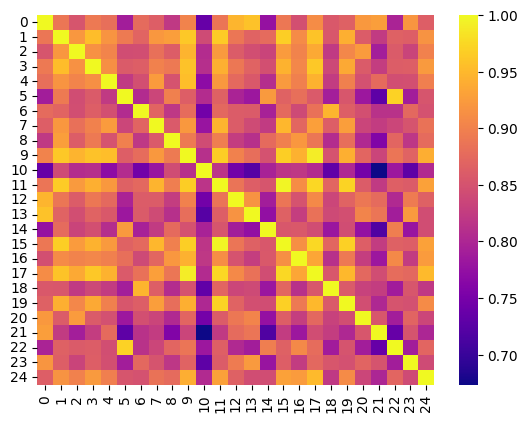

In [ ]:
#Generar el gráfico de tipo heatmap de la tabla de datos
heatmap = sns.heatmap(data=table,cmap='plasma')

# Mostrar el gráfico
plt.show()

Esta visualización no nos permite distinguir a simple vista cuales moléculas tienen mayor similitud.

Para poder hacerlo, podemos agruparlas usando algoritmos de clusterización.

La función `linkage()` es una función del módulo `scipy.cluster.hierarchy` que se utiliza para realizar la vinculación aglomerativa en análisis de agrupamiento (*clustering*).

Es un *clustering* que comienza considerando cada punto (en este caso, moléculas) como un *cluster* individual y luego combina iterativamente los *clusters* más similares en *clusteres* más grandes.

In [ ]:
# Realizar la clusterización utilizando el método single de la matriz de similitud 'hmap'
linked = linkage(hmap, 'complete')

# Verifica la validez de la matriz
print(is_valid_linkage(linked))

# Crear una lista de etiquetas 'labelList' para las moléculas en la tabla 'tabla_CHEMBL674637'
labelList = [tabla_CHEMBL674637['ID'][i] for i in range(len(tabla_CHEMBL674637))]

True


La función tiene cuatro métodos para calcular distancias:

*  Single: la distancia entre dos grupos es la distancia mínima entre los miembros de los dos grupos

`linked = linkage(hmap, 'single')`

*  Complete: la distancia entre dos clústeres es la distancia máxima entre los miembros de los dos clústeres

`linked = linkage(hmap, 'complete')`

*  Average: la distancia entre dos grupos es el promedio de todas las distancias entre los miembros de los dos grupos.

`linked = linkage(hmap, 'average')`

*  Centroid: la distancia entre dos grupos es la distancia entre sus centroides

`linked = linkage(hmap, 'centroid')`

Si quieren profundizar sobre esta función pueden leer su [documentación](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)

El resultado final es una estructura jerárquica de *clusteres* que puede visualizarse como un dendrograma. Para poder hacer esta visualización primero vamos a definir la función para generarlo:

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Crea una matriz de clustering y luego traza el dendrograma

    # Crea los conteos de muestras bajo cada nodo
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Nodo hoja
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Trama el dendrograma correspondiente
    dendrogram(linkage_matrix, **kwargs)

Luego de definir la función, vamos a generar el dendograma

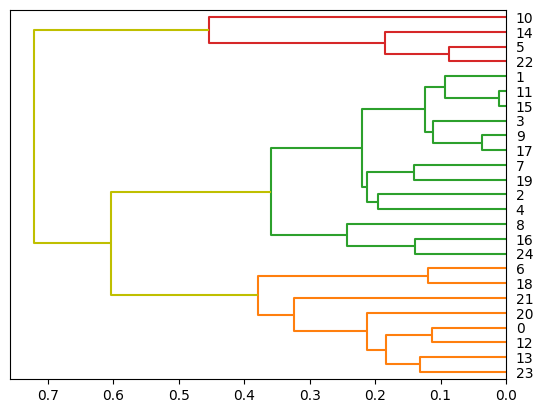

In [ ]:
# Generar el dendrograma
o = dendrogram(linked, orientation='left', labels=labelList, distance_sort='descending', show_leaf_counts=True,  above_threshold_color='y')

Por último, vamos a generar un grafico que muestre la similitud y como se clusterizan las moléculas!

Primero vamos a ordenar las moléculas del heatmap para que coincidan con el roden del dendograma

In [ ]:
# Esto nos dará los clústeres en orden según el último dendrograma
new_data = list(reversed(o['ivl']))

# Creamos una nueva tabla con el orden del agrupamiento jerárquico (HCL)
hmap_2 = np.empty(shape=(size, size))
for index, i in enumerate(new_data):
    for jndex, j in enumerate(new_data):
        hmap_2[index, jndex] = table.loc[i].at[j]

Y luego vamos a generar una figura que contenga el dendograma y el heatmap

[]

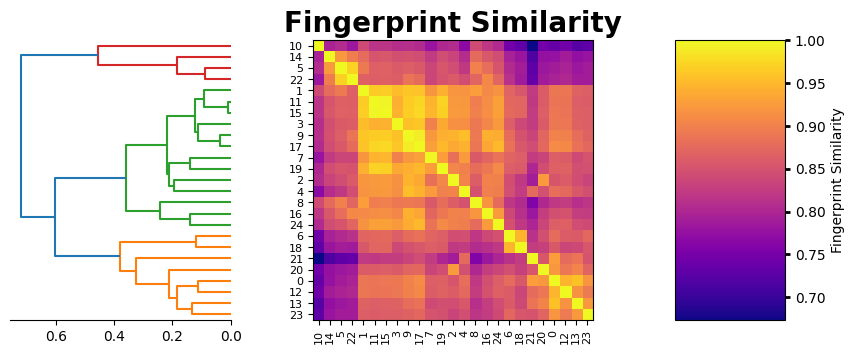

In [ ]:
# Crear una figura con tamaño de 10x8 pulgadas
figure = plt.figure(figsize=(10,8))

# Crear una rejilla de subtramas con 2 filas y 7 columnas
gs1 = gridspec.GridSpec(2, 7)
gs1.update(wspace=0.01)

# Subtrama para el dendrograma
ax1 = plt.subplot(gs1[0:-1, :2])
dendrogram(linked, orientation='left', distance_sort='descending', show_leaf_counts=True, no_labels=True)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Subtrama para la matriz de similitud
ax2 = plt.subplot(gs1[0:-1, 2:6])
f = ax2.imshow(hmap_2, cmap='plasma', interpolation='nearest')
ax2.set_title('Fingerprint Similarity', fontsize=20, weight='bold')
ax2.set_xticks(range(len(new_data)))
ax2.set_yticks(range(len(new_data)))
ax2.set_xticklabels(new_data, rotation=90, size=8)
ax2.set_yticklabels(new_data, size=8)

# Subtrama para la barra de color
ax3 = plt.subplot(gs1[0:-1, 6:7])
m = plt.colorbar(f, cax=ax3, shrink=0.75, orientation='vertical', spacing='uniform', pad=0.01)
m.set_label('Fingerprint Similarity')

# Configurar los parámetros de las etiquetas de los ejes
plt.tick_params('both', width=2)

# Mostrar el gráfico
plt.plot()

Con el dendograma podemos ver que los compuestos se agrupan dentro de un cluster grande con 23 moléculas y otro más pequeño con 2 moléculas.

Podemos visualizar evaluar la clusterización visualizando dos moléculas que fueron clasificadas como similares:

In [ ]:
#Elegir dos moléculas para comparar
numero_compuesto_1 = 10
numero_compuesto_2 = 21

0.6734828496042217


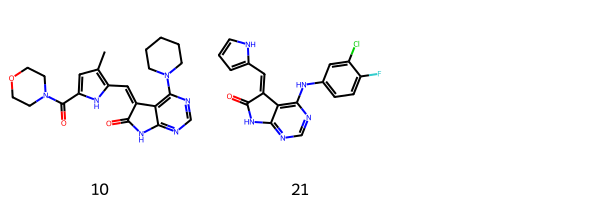

In [ ]:
# Calcular la similitud de huellas moleculares entre los dos compuestos
similarity = DataStructs.FingerprintSimilarity(fps[numero_compuesto_1], fps[numero_compuesto_2])
print(similarity)

# Mostrar las moléculas en una cuadrícula con sus leyendas
Draw.MolsToGridImage([tabla_CHEMBL674637['ROMol'][numero_compuesto_1], tabla_CHEMBL674637['ROMol'][numero_compuesto_2]], legends=[str(numero_compuesto_1), str(numero_compuesto_2)])

¿Que conclusiones pueden sacar al comparar visualmente estas dos moléculas?

Si comparamos lo observado en el dendograma con el heatmap vemos que los compuestos se agrupan en más de dos clusters!

Por último, podemos agregar una columna para indicar en que cluster se encuentra cada molécula:

ID                                             smiles  \
0    0  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   
1    1  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
2    2  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...   
3    3  CCN(CC)CC(O)CNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc...   
4    4  O=C1Nc2ncnc(Nc3ccc(F)c(Cl)c3)c2/C1=C/c1ccc(C(=...   
5    5  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
6    6  CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ncnc(...   
7    7  Cc1cc(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c32)...   
8    8  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
9    9  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncn...   
10  10  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
11  11  CCN1CCN(C(=O)c2cc(C)c(/C=C3\C(=O)Nc4ncnc(Nc5cc...   
12  12  Cc1cc(C(=O)O)[nH]c1/C=C1\C(=O)Nc2ncnc(Nc3ccc(F...   
13  13  Cc1cc(CCC(=O)O)[nH]c1/C=C1\C(=O)Nc2ncnc(Nc3ccc...   
14  14  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
15  15  Cc1cc(C(=O)N2CCN(C)CC2)[nH]c1/C=C1\C(=O)Nc2ncn...   
16  16  C#Cc1cccc(Nc2ncnc3c2/C(=C/c2[nH]c(C(=O)NCCN4CC...   
17  17  CCN(CC)CCNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4...   
18  18  Cc1c(C(=O)N2CCN(C)CC2)c[nH]c1/C=C1\C(=O)Nc2ncn...   
19  19  Cc1cc(C(=O)N2CC(C)NC(C)C2)[nH]c1/C=C1\C(=O)Nc2...   
20  20  Cc1cc(C)c(/C=C2\C(=O)N(C)c3ncnc(Nc4ccc(F)c(Cl)...   
21  21    O=C1Nc2ncnc(Nc3ccc(F)c(Cl)c3)c2/C1=C/c1ccc[nH]1   
22  22  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncn...   
23  23  Cc1[nH]c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c...   
24  24  CCN(CC)CCNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4...   

                                               ROMol  Cluster_fingerprints  
0   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5b60>                     0  
1   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5d20>                     1  
2   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5f50>                     1  
3   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5d90>                     1  
4   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5fc0>                     1  
5   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6030>                     2  
6   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad60a0>                     0  
7   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6110>                     1  
8   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6180>                     1  
9   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad61f0>                     1  
10  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6260>                     2  
11  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad62d0>                     1  
12  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6340>                     0  
13  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad63b0>                     0  
14  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6420>                     2  
15  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6490>                     1  
16  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6500>                     1  
17  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6570>                     1  
18  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad65e0>                     0  
19  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6650>                     1  
20  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad66c0>                     0  
21  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6730>                     0  
22  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad67a0>                     2  
23  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6810>                     0  
24  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6880>                     1
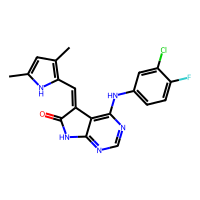
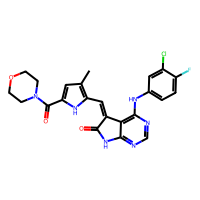
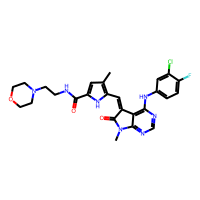
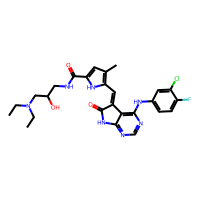
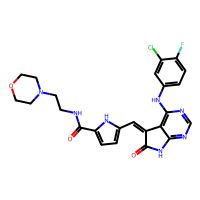
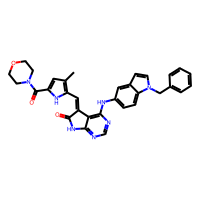
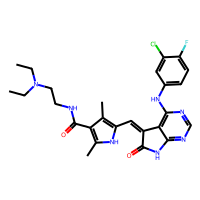
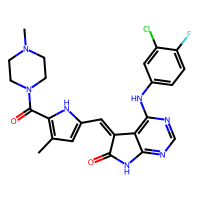
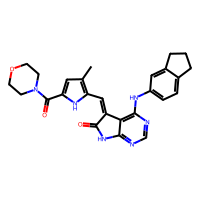
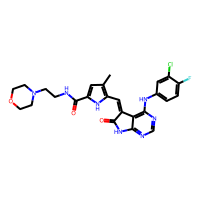
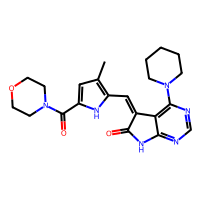
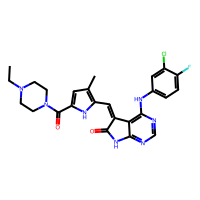
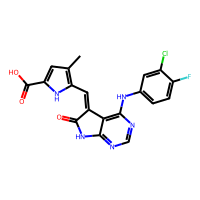
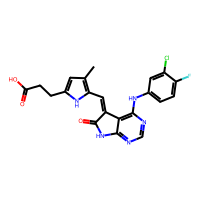
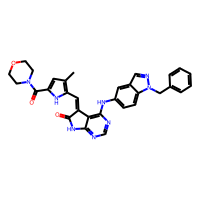
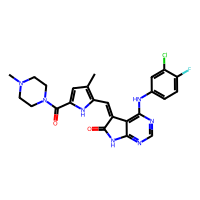
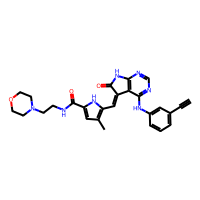
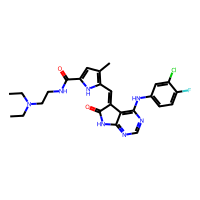
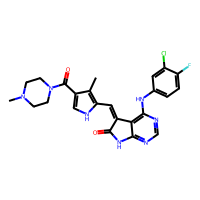
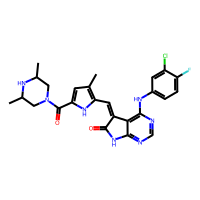
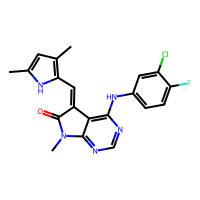
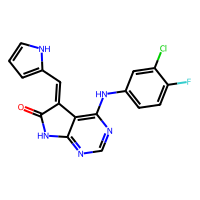
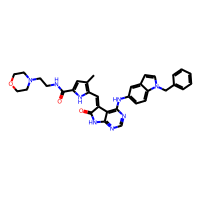
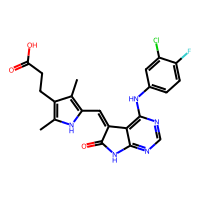
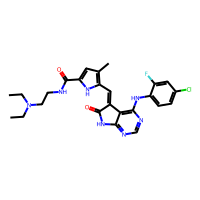

In [ ]:
# Indicar la cantidad de clusters:
n = 3

# Obtener los clusters utilizando cut_tree con un número específico de clusters
clusters = cut_tree(linked, n)

# Agregar el número de cluster a la tabla
tabla_CHEMBL674637['Cluster_fingerprints'] = clusters.flatten()
tabla_CHEMBL674637

Puedo separar los datos por clusters:

In [ ]:
tabla_CHEMBL674637 = tabla_CHEMBL674637.loc[tabla_CHEMBL674637['Cluster_fingerprints'] == 0]
tabla_CHEMBL674637 = tabla_CHEMBL674637.loc[tabla_CHEMBL674637['Cluster_fingerprints'] == 1]
tabla_CHEMBL674637 = tabla_CHEMBL674637.loc[tabla_CHEMBL674637['Cluster_fingerprints'] == 2]

Actividad N°1
¿Cómo quedaron agrupadas las moléculas que evaluamos anteriormente?

Vamos comparar los siguientes pares:
*  Molécula 1 con 0
*  Molécula 1 con 2
*  Molécula 11 con 15

Evaluar su similitud y ver su ubicación en el dendograma

❗ Escribí los comandos necesarios en la celda que se encuentra debajo

👇

# Parte 2: Clusterización por PCA


## Exploración del espacio químico usando Principal Component Analysis (PCA)

El Análisis de Componentes Principales (PCA, por sus siglas en inglés) es una técnica estadística utilizada para reducir la dimensionalidad de conjuntos de datos de alta dimensionalidad. PCA busca encontrar las direcciones principales (componentes principales) a lo largo de las cuales los datos presentan la mayor variabilidad. Estas direcciones principales son ortogonales entre sí y ordenadas por su importancia relativa en términos de la variabilidad explicada.

El objetivo principal de PCA es simplificar y visualizar datos complejos al proyectarlos en un nuevo sistema de coordenadas definido por los componentes principales. Al realizar esta proyección, PCA resume la información contenida en múltiples variables en un número reducido de componentes principales que capturan la mayor parte de la variabilidad de los datos.

In [ ]:
# Calcular propiedades moleculares de la tabla CHEMBL674637

for i in range(len(tabla_CHEMBL674637)):
    mol = tabla_CHEMBL674637['ROMol'][i]

    # Calcular el peso molecular exacto
    tabla_CHEMBL674637.loc[i, 'MW'] = Descriptors.ExactMolWt(mol)

    # Calcular el área de superficie polar topológica (TPSA)
    tabla_CHEMBL674637.loc[i, 'TPSA'] = Chem.rdMolDescriptors.CalcTPSA(mol)

    # Calcular el número de enlaces rotativos (nRotB)
    tabla_CHEMBL674637.loc[i, 'nRotB'] = Descriptors.NumRotatableBonds(mol)

    # Calcular el número de donantes de enlaces de hidrógeno (HBD)
    tabla_CHEMBL674637.loc[i, 'HBD'] = Descriptors.NumHDonors(mol)

    # Calcular el número de aceptores de enlaces de hidrógeno (HBA)
    tabla_CHEMBL674637.loc[i, 'HBA'] = Descriptors.NumHAcceptors(mol)

    # Calcular el logaritmo del coeficiente de partición octanol-agua (logP)
    tabla_CHEMBL674637.loc[i, 'logP'] = Descriptors.MolLogP(mol)

❗ Escribí la tabla que generamos en la celda que se encuentra debajo

👇

ID                                             smiles  \
0    0  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   
1    1  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
2    2  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...   
3    3  CCN(CC)CC(O)CNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc...   
4    4  O=C1Nc2ncnc(Nc3ccc(F)c(Cl)c3)c2/C1=C/c1ccc(C(=...   
5    5  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
6    6  CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ncnc(...   
7    7  Cc1cc(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c32)...   
8    8  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
9    9  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncn...   
10  10  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
11  11  CCN1CCN(C(=O)c2cc(C)c(/C=C3\C(=O)Nc4ncnc(Nc5cc...   
12  12  Cc1cc(C(=O)O)[nH]c1/C=C1\C(=O)Nc2ncnc(Nc3ccc(F...   
13  13  Cc1cc(CCC(=O)O)[nH]c1/C=C1\C(=O)Nc2ncnc(Nc3ccc...   
14  14  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
15  15  Cc1cc(C(=O)N2CCN(C)CC2)[nH]c1/C=C1\C(=O)Nc2ncn...   
16  16  C#Cc1cccc(Nc2ncnc3c2/C(=C/c2[nH]c(C(=O)NCCN4CC...   
17  17  CCN(CC)CCNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4...   
18  18  Cc1c(C(=O)N2CCN(C)CC2)c[nH]c1/C=C1\C(=O)Nc2ncn...   
19  19  Cc1cc(C(=O)N2CC(C)NC(C)C2)[nH]c1/C=C1\C(=O)Nc2...   
20  20  Cc1cc(C)c(/C=C2\C(=O)N(C)c3ncnc(Nc4ccc(F)c(Cl)...   
21  21    O=C1Nc2ncnc(Nc3ccc(F)c(Cl)c3)c2/C1=C/c1ccc[nH]1   
22  22  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncn...   
23  23  Cc1[nH]c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c...   
24  24  CCN(CC)CCNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4...   

                                               ROMol  Cluster_fingerprints  \
0   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5b60>                     0   
1   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5d20>                     1   
2   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5f50>                     1   
3   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5d90>                     1   
4   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5fc0>                     1   
5   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6030>                     2   
6   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad60a0>                     0   
7   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6110>                     1   
8   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6180>                     1   
9   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad61f0>                     1   
10  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6260>                     2   
11  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad62d0>                     1   
12  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6340>                     0   
13  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad63b0>                     0   
14  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6420>                     2   
15  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6490>                     1   
16  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6500>                     1   
17  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6570>                     1   
18  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad65e0>                     0   
19  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6650>                     1   
20  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad66c0>                     0   
21  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6730>                     0   
22  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad67a0>                     2   
23  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6810>                     0   
24  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6880>                     1   

            MW    TPSA  nRotB  HBD  HBA     logP  
0   383.094916   82.70    3.0  3.0  4.0  4.45034  
1   482.126944  112.24    4.0  3.0  6.0  3.61432  
2   539.184794  115.48    7.0  3.0  7.0  3.22822  
3   541.200444  135.27   10.0  5.0  7.0  3.57442  
4   511.153493  124.27    7.0  4.0  7.0  2.89550  
5   559.233188  117.17    6.0  3.0  7.0  4.82482  
6   525.205529  115.04    9.0  
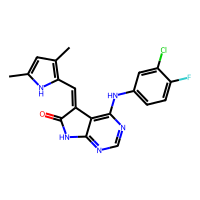
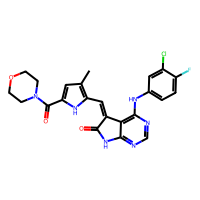
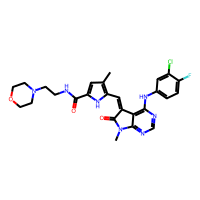
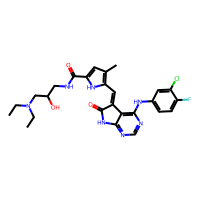
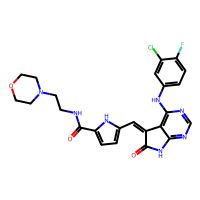
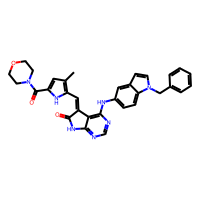
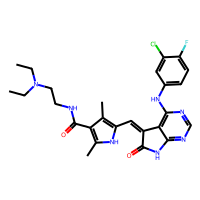
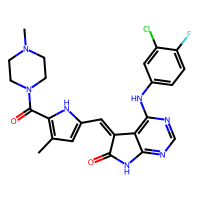
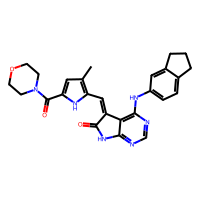
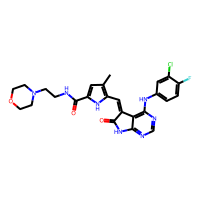
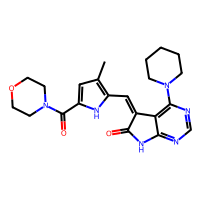
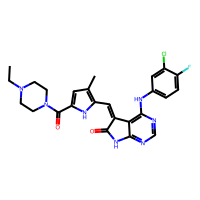
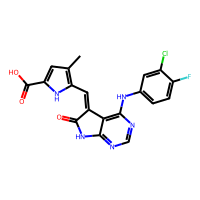
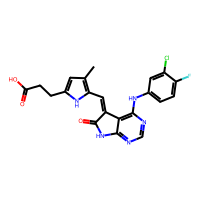
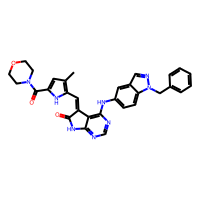
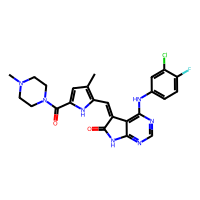
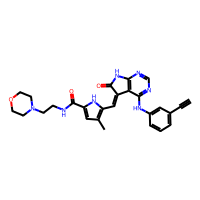
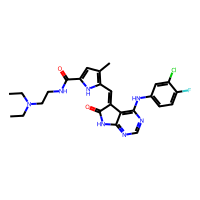
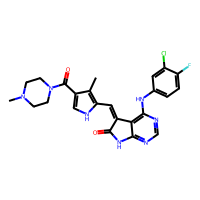
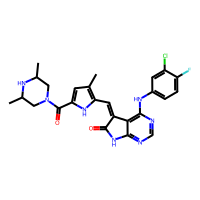
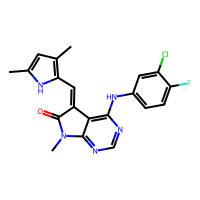
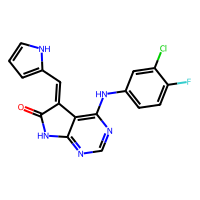
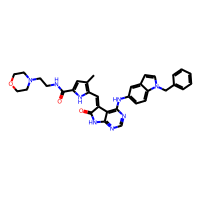
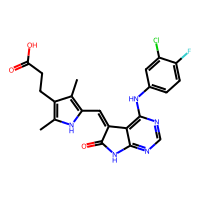
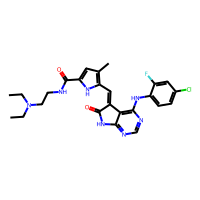

In [ ]:
tabla_CHEMBL674637

En la siguiente celda, se lleva a cabo un análisis de los descriptores moleculares de la tabla.

En primer lugar se extraen los descriptores moleculares relevantes de la tabla, que incluyen propiedades físico-químicas como:
* el peso molecular (MW),
* el área de superficie polar topológica (TPSA),
* el número de enlaces rotables (nRotB),
* el número de donadores de enlaces de hidrógeno (HBD),
* el número de aceptores de enlaces de hidrógeno (HBA) y
* el valor de logP.

En segundo lugar, se normalizan los descriptores utilizando la técnica de escala estándar (StandardScaler) para asegurar que todas las variables tengan la misma escala y sean comparables entre sí.

Por último, se aplica el PCA a los descriptores normalizados utilizando la función `PCA()`.

Como ya dijimos antes, PCA reduce la dimensionalidad de los descriptores y encuentra combinaciones lineales de variables que explican la mayor parte de la variabilidad de los datos.

El resultado es un conjunto de nuevas variables llamadas Componentes Principales (**P**rincipal **C**omponents).

La función `PCA()` devuelve los componentes principales que luego convertiremos a un DataFrame llamado `descriptors_pca`, donde cada columna representa una PC y cada fila corresponde a una molécula de la `tabla_CHEMBL674637`.

In [ ]:
#@title Cálculo de PCA
# Paso 1: Obtener los descriptores moleculares de la tabla CHEMBL674637
descriptors = tabla_CHEMBL674637.loc[:, ['MW', 'TPSA', 'nRotB', 'HBD','HBA', 'logP']].values

# Paso 2: Normalizar los descriptores utilizando StandardScaler
descriptors_std = StandardScaler().fit_transform(descriptors)

# Paso 3: Aplicar PCA a los descriptores normalizados
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)

# Formateo de datos
# Crear un DataFrame con las coordenadas PCA
descriptors_pca = pd.DataFrame(descriptors_2d)

# Establecer el índice del DataFrame como el índice de la tabla CHEMBL674637
descriptors_pca.index = tabla_CHEMBL674637.index

# Etiquetar las columnas del DataFrame como PC1, PC2, PC3, etc.
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]

# Mostrar el DataFrame con las coordenadas PCA
# descriptors_pca

Ahora vamos a generar un gráfico de dispersión bidimensional para visualizar la proyección de las muestras en el espacio de las dos primeras componentes principales obtenidas mediante PCA. El código para generar este gráfico es complejo, pero pueden utilizarlo para realizar el gráfico accediendo a la celda que se encuentra debajo.

El gráfico nos permite explorar y comprender la estructura y variabilidad de los datos en un espacio de menor dimensión.

Cada punto en el gráfico representa una muestra del conjunto de datos. La posición de cada punto en el *eje x* está determinada por el valor de la primera componente principal (PC1), mientras que la posición en el eje y está determinada por el valor de la segunda componente principal (PC2).

Este gráfico muestra los datos normalizados.

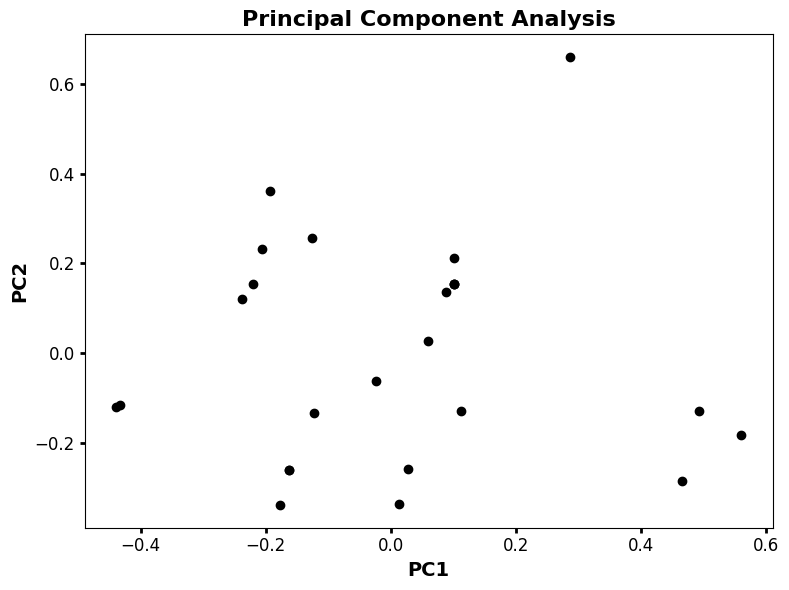

In [ ]:
#@title Gráfico de PCA normalizado
# Calculamos la escala para normalizar las componentes principales
scale1 = 1.0 / (max(descriptors_pca['PC1']) - min(descriptors_pca['PC1']))
scale2 = 1.0 / (max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))

# Normalizamos las componentes principales y las almacenamos en nuevas columnas
descriptors_pca['PC1_normalized'] = [i * scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized'] = [i * scale2 for i in descriptors_pca['PC2']]

# Crear una nueva figura con tamaño de 8x6 pulgadas
fig = plt.figure(figsize=(8, 6))

# Agregar un único subplot en la figura
ax = fig.add_subplot(111)

# Graficar las componentes principales normalizadas
ax.plot(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'], 'o', color='k')

# Establecer el título del gráfico
ax.set_title('Principal Component Analysis', fontsize=16, fontweight='bold', family='sans-serif')

# Etiquetar el eje x
ax.set_xlabel('PC1', fontsize=14, fontweight='bold')

# Etiquetar el eje y
ax.set_ylabel('PC2', fontsize=14, fontweight='bold')

# Configurar los parámetros de las marcas en los ejes
plt.tick_params('both', width=2, labelsize=12)

# Ajustar el diseño del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Agrupación por K-means

El algoritmo de K-means es un método popular para la agrupación de datos. Su objetivo principal es dividir un conjunto de datos en K grupos o clusters, donde cada punto de datos se asigna al cluster más cercano a su centroide.

![imagen](https://miro.medium.com/v2/resize:fit:1200/1*rw8IUza1dbffBhiA4i0GNQ.png)

El número K se define de antemano y representa el número de clusters que se desea obtener.

In [ ]:
# Número de clusters a evaluar
range_K_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]


Ahora vamos a probar como se agrupan los resultados con diferentes K de clusters definiendo una función que genera la clusterización y el análisis de la silueta para cada uno

Para n_clusters = 2 El coeficiente de silueta promedio es: 0.3408941091610987
Para n_clusters = 3 El coeficiente de silueta promedio es: 0.47805490011263146
Para n_clusters = 4 El coeficiente de silueta promedio es: 0.5019298643545224
Para n_clusters = 5 El coeficiente de silueta promedio es: 0.503050058458543
Para n_clusters = 6 El coeficiente de silueta promedio es: 0.5906441107512436
Para n_clusters = 7 El coeficiente de silueta promedio es: 0.579470510676593
Para n_clusters = 8 El coeficiente de silueta promedio es: 0.5896992016131033
Para n_clusters = 9 El coeficiente de silueta promedio es: 0.5386018991687057
Para n_clusters = 10 El coeficiente de silueta promedio es: 0.5468264534842077


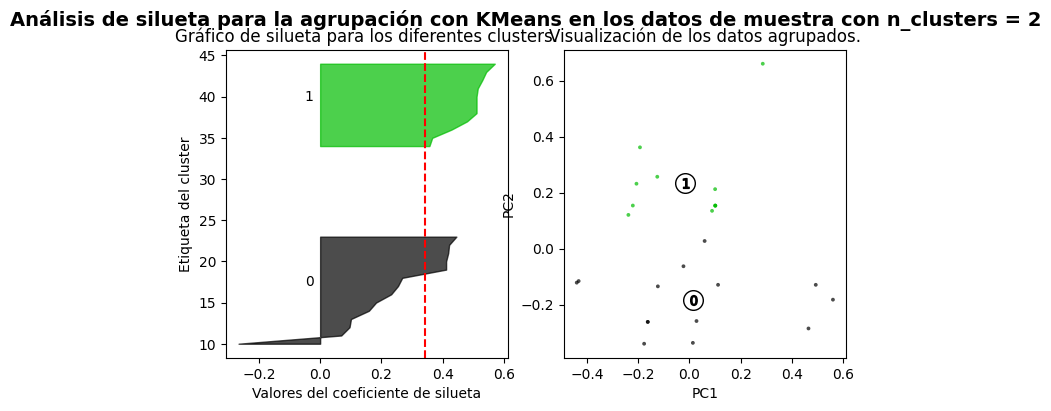

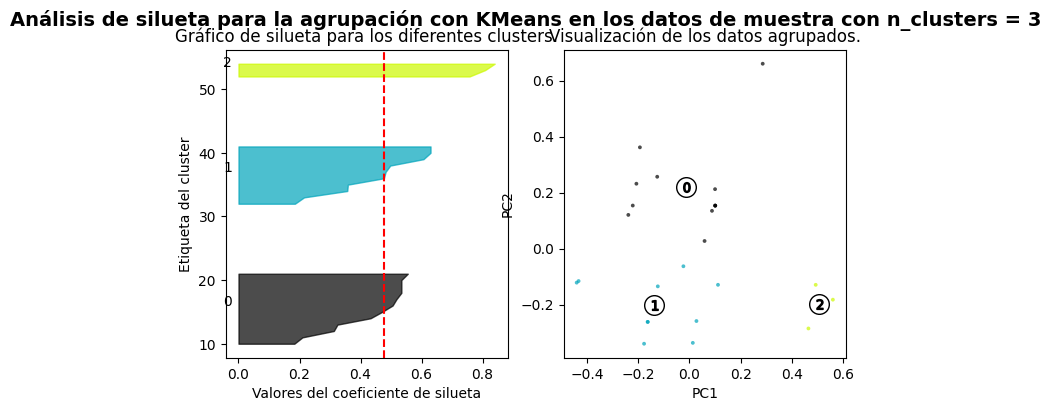

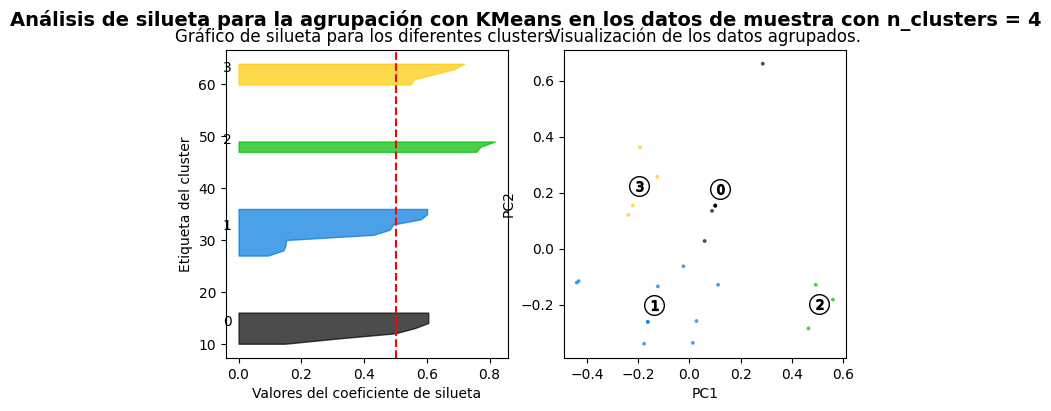

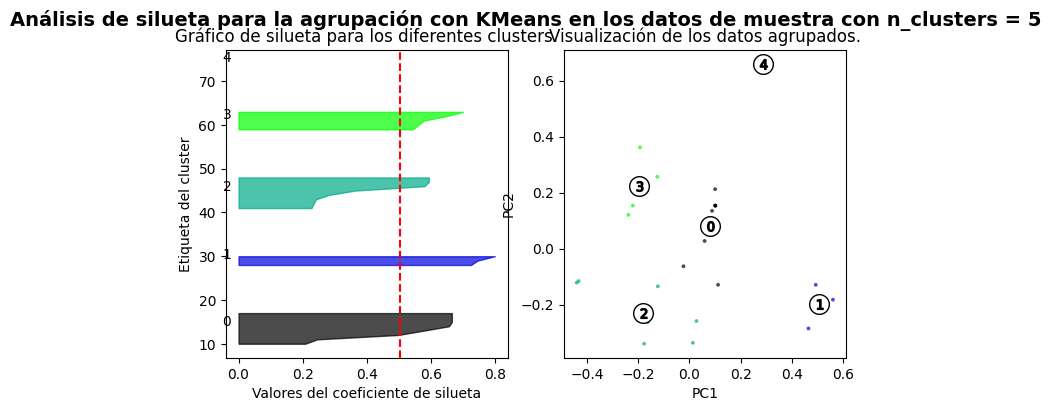

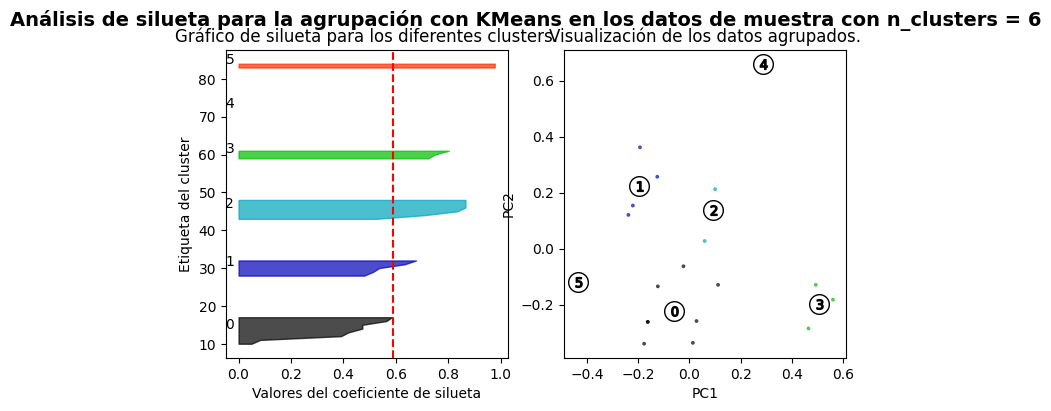

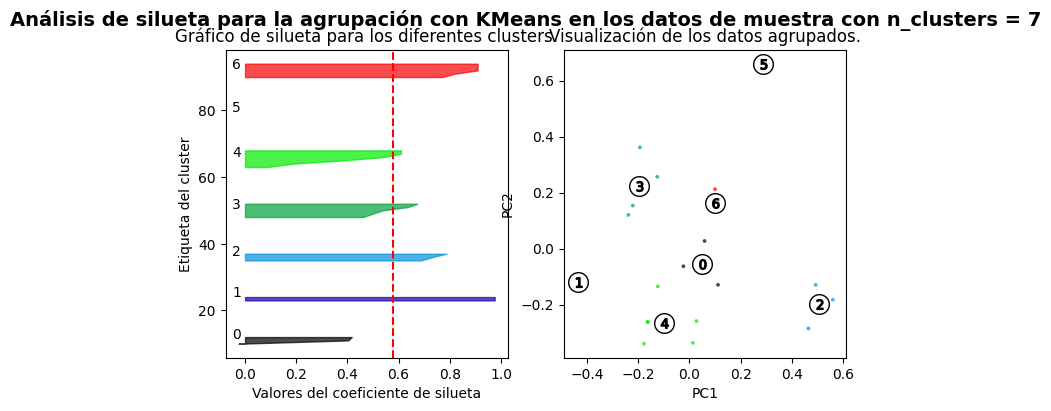

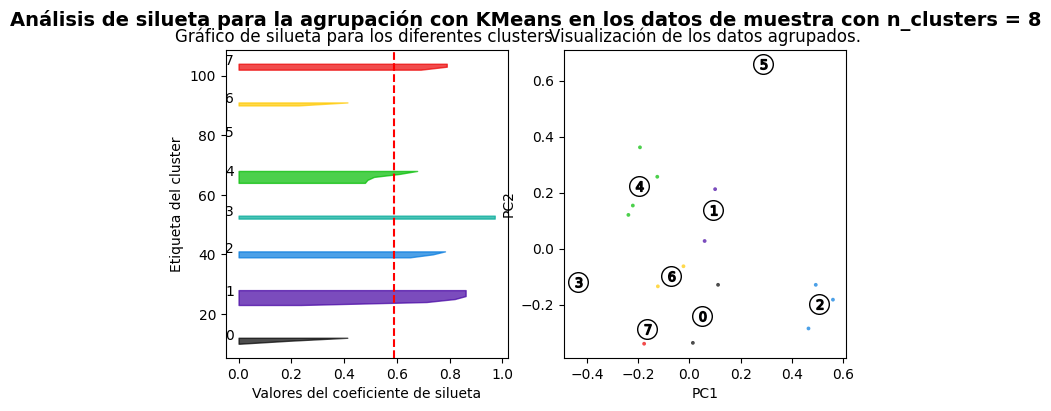

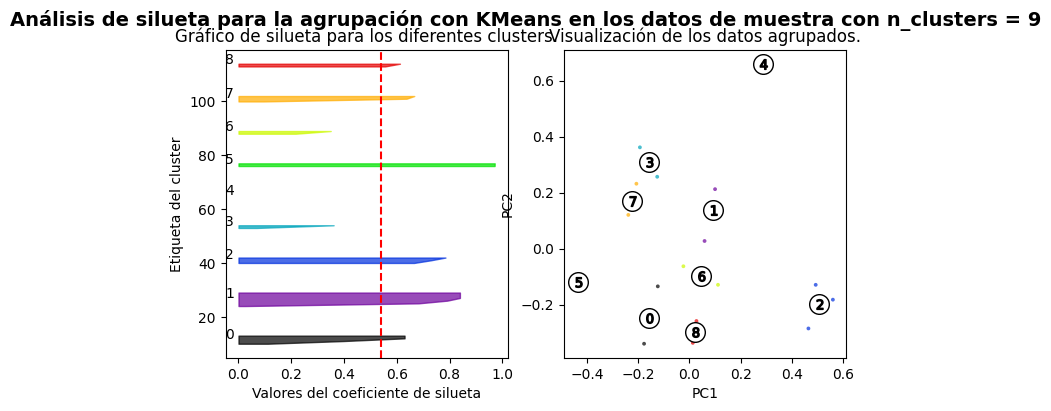

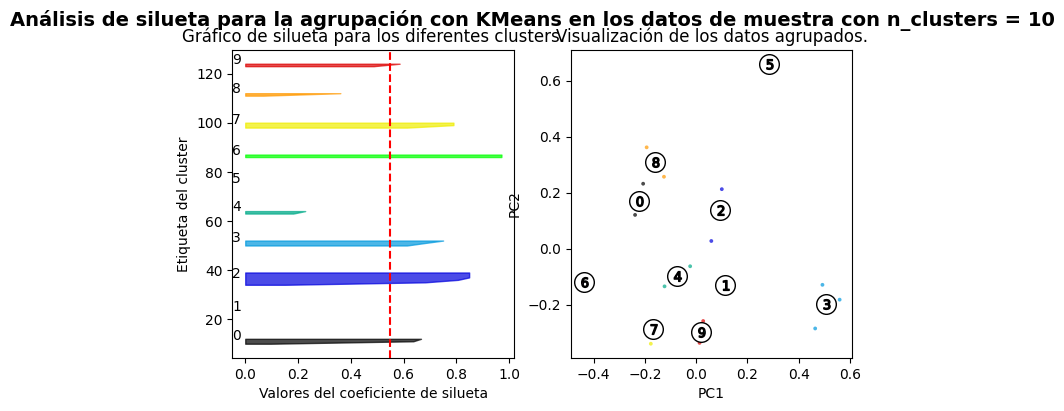

In [ ]:
#@title Evaluación del mejor número de clusters
# Realizamos el análisis de silueta para diferentes valores de K (número de clusters)
for n_clusters in range_K_clusters:
    warnings.filterwarnings('ignore', category=FutureWarning)
    # Creamos una figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)

    # Creamos una instancia del algoritmo KMeans con el número de clusters deseado
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)

    # Aplicamos el algoritmo a las componentes principales normalizadas
    cluster_labels = kmeans.fit_predict(descriptors_pca[['PC1_normalized', 'PC2_normalized']])

    # Calculamos el coeficiente de silueta promedio para evaluar la calidad de los clusters
    silhouette_avg = silhouette_score(descriptors_pca[['PC1_normalized', 'PC2_normalized']], cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El coeficiente de silueta promedio es:", silhouette_avg)

    # Calculamos los valores de silueta para cada muestra
    sample_silhouette_values = silhouette_samples(descriptors_pca[['PC1_normalized', 'PC2_normalized']], cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        # Agrupamos los valores de silueta para las muestras pertenecientes al cluster i y los ordenamos
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Definimos un color para el cluster i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Etiquetamos los gráficos de silueta con los números de cluster
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Calculamos el nuevo valor de y_lower para el próximo gráfico
        y_lower = y_upper + 10  # 10 para las muestras con valor 0

    # Configuramos el primer subplot (gráfico de silueta)
    ax1.set_title("Gráfico de silueta para los diferentes clusters.")
    ax1.set_xlabel("Valores del coeficiente de silueta")
    ax1.set_ylabel("Etiqueta del cluster")

    # Agregamos una línea vertical para el coeficiente de silueta promedio
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    # Configuramos el segundo subplot (visualización de los clusters)
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'],
                marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Etiquetamos los clusters
    centers = kmeans.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    # Iterar sobre los centroides de los clusters y graficarlos en el subplot ax2
    for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')
    # Configurar título y etiquetas de los ejes del subplot ax2
      ax2.set_title("Visualización de los datos agrupados.")
      ax2.set_xlabel("PC1")
      ax2.set_ylabel("PC2")

    # Configurar título principal de la figura con información del análisis de silueta
    plt.suptitle(("Análisis de silueta para la agrupación con KMeans en los datos de muestra con n_clusters = %d" % n_clusters),
                              fontsize=14, fontweight='bold')

# Mostrar la figura completa
plt.show()

A medida que el `silhouette_score` es mayor, la distribución de los datos en *clusters* es mejor.

Entonces, para nuestros datos:

Para n_clusters = 6, el silhouette_score promedio es: 0.5906441107512436

La mejor agrupación de nuestros datos es de seis *clusters*

In [ ]:
#Definimos el número de clusters
n_clusters = 6

In [ ]:
#@title Número de clústeres óptimo (n_clusters)
# Creamos una instancia del algoritmo K-means con el número de clústeres óptimo y una semilla aleatoria
kmeans = KMeans(n_clusters=n_clusters, random_state=10)

# Aplicamos el algoritmo K-means a las componentes principales PC1 y PC2 (valores normalizados)
clusters = kmeans.fit(descriptors_pca[['PC1_normalized','PC2_normalized']])

# Creamos un DataFrame vacío para almacenar la información de los clústeres
cluster_info = pd.DataFrame()

# Agregamos la columna 'ID' con los índices de la tabla original
cluster_info['ID'] = tabla_CHEMBL674637.index

# Agregamos la columna 'cluster' con las etiquetas de clúster asignadas por K-means
cluster_info['cluster'] = clusters.labels_


Vamos a graficar los datos de PC1 vs PC2. Cada cluster tendrá un color diferente.

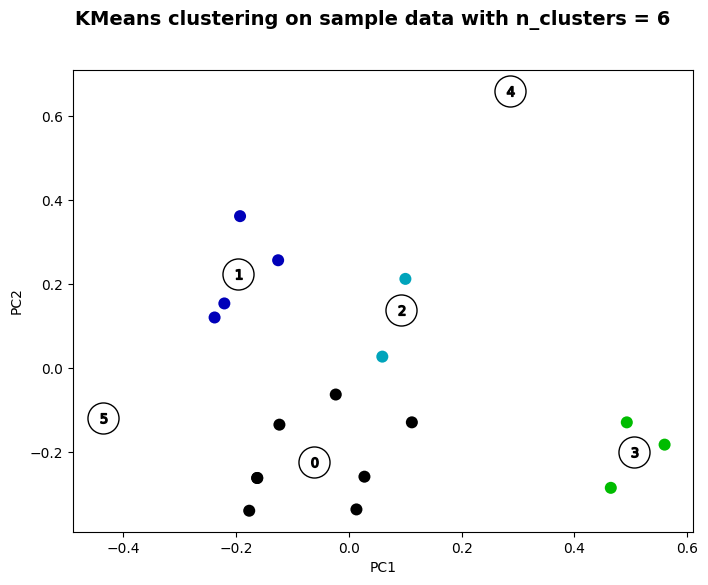

In [ ]:
#@title Gráfico de PCA normalizado con los clusters diferenciados
# Creamos una figura con un único subplot
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(8, 6)

# Creamos una instancia del algoritmo K-means con el número de clústeres óptimo y una semilla aleatoria
kmeans = KMeans(n_clusters=n_clusters, random_state=10)

# Aplicamos el algoritmo K-means a las componentes principales PC1 y PC2 (valores normalizados)
cluster_labels = kmeans.fit_predict(descriptors_pca[['PC1_normalized','PC2_normalized']])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
plt.scatter(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'],
                marker='.', s=300, lw=0, alpha=1,c=colors, edgecolor='k')

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=500, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')
    # Establecemos las etiquetas de los ejes
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")

# Título principal de la figura
plt.suptitle(("KMeans clustering on sample data "
                "with n_clusters = %d" % n_clusters),
                fontsize=14, fontweight='bold')

# Guardamos la figura en un archivo
plt.savefig('KMeans_clustering.png')

# Mostramos la figura
plt.show()

Con este comando le agregamos a la tabla una columna indicando en que cluster está cada molécula

In [ ]:
#@title Agregar etiquetas con el número de cluster a la tabla
# Agregamos la columna 'Cluster_PC1_PC2' al DataFrame 'descriptors_pca' con las etiquetas de los clusters
descriptors_pca['Cluster_PC1_PC2'] = clusters.labels_

# Agregamos la columna 'clusters' al DataFrame 'tabla_CHEMBL674637' con las etiquetas de los clusters
tabla_CHEMBL674637['Cluster_PCA'] = clusters.labels_

ID                                             smiles  \
0    0  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   
1    1  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
2    2  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...   
3    3  CCN(CC)CC(O)CNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc...   
4    4  O=C1Nc2ncnc(Nc3ccc(F)c(Cl)c3)c2/C1=C/c1ccc(C(=...   
5    5  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
6    6  CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ncnc(...   
7    7  Cc1cc(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c32)...   
8    8  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
9    9  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncn...   
10  10  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
11  11  CCN1CCN(C(=O)c2cc(C)c(/C=C3\C(=O)Nc4ncnc(Nc5cc...   
12  12  Cc1cc(C(=O)O)[nH]c1/C=C1\C(=O)Nc2ncnc(Nc3ccc(F...   
13  13  Cc1cc(CCC(=O)O)[nH]c1/C=C1\C(=O)Nc2ncnc(Nc3ccc...   
14  14  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
15  15  Cc1cc(C(=O)N2CCN(C)CC2)[nH]c1/C=C1\C(=O)Nc2ncn...   
16  16  C#Cc1cccc(Nc2ncnc3c2/C(=C/c2[nH]c(C(=O)NCCN4CC...   
17  17  CCN(CC)CCNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4...   
18  18  Cc1c(C(=O)N2CCN(C)CC2)c[nH]c1/C=C1\C(=O)Nc2ncn...   
19  19  Cc1cc(C(=O)N2CC(C)NC(C)C2)[nH]c1/C=C1\C(=O)Nc2...   
20  20  Cc1cc(C)c(/C=C2\C(=O)N(C)c3ncnc(Nc4ccc(F)c(Cl)...   
21  21    O=C1Nc2ncnc(Nc3ccc(F)c(Cl)c3)c2/C1=C/c1ccc[nH]1   
22  22  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncn...   
23  23  Cc1[nH]c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c...   
24  24  CCN(CC)CCNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4...   

                                               ROMol  Cluster_fingerprints  \
0   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5b60>                     0   
1   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5d20>                     1   
2   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5f50>                     1   
3   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5d90>                     1   
4   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5fc0>                     1   
5   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6030>                     2   
6   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad60a0>                     0   
7   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6110>                     1   
8   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6180>                     1   
9   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad61f0>                     1   
10  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6260>                     2   
11  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad62d0>                     1   
12  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6340>                     0   
13  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad63b0>                     0   
14  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6420>                     2   
15  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6490>                     1   
16  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6500>                     1   
17  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6570>                     1   
18  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad65e0>                     0   
19  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6650>                     1   
20  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad66c0>                     0   
21  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6730>                     0   
22  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad67a0>                     2   
23  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6810>                     0   
24  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6880>                     1   

            MW    TPSA  nRotB  HBD  HBA     logP  Cluster_PCA  
0   383.094916   82.70    3.0  3.0  4.0  4.45034            3  
1   482.126944  112.24    4.0  3.0  6.0  3.61432            2  
2   539.184794  115.48    7.0  3.0  7.0  3.22822            1  
3   541.200444  135.27   10.0  5.0  7.0  3.57442            5  
4   511.153493  124.27    7.0  4.0  7.0  2.89550            1  
5   
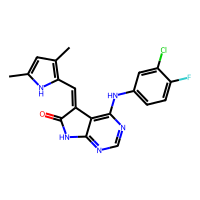
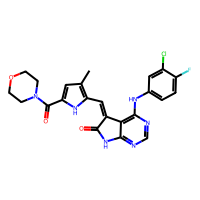
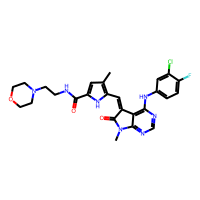
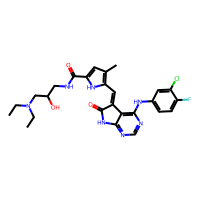
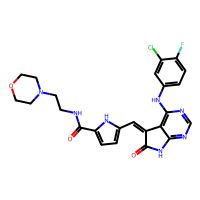
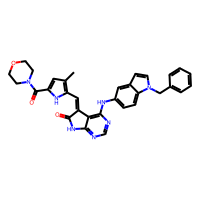
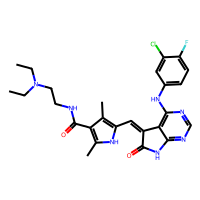
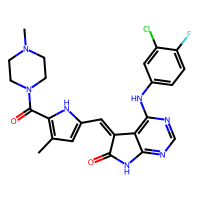
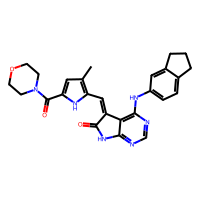
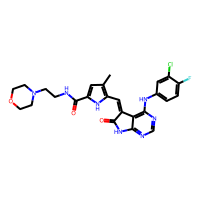
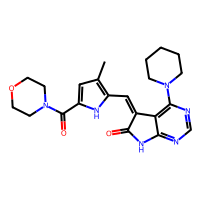
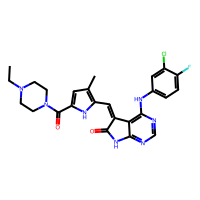
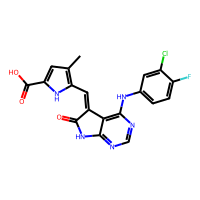
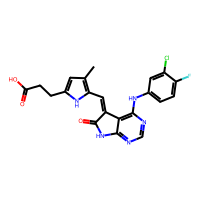
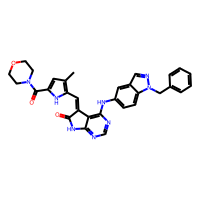
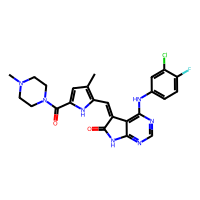
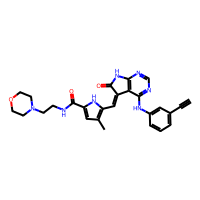
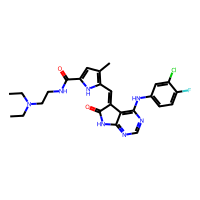
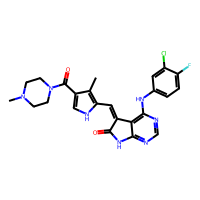
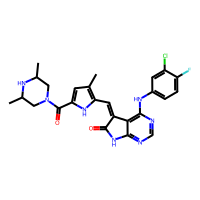
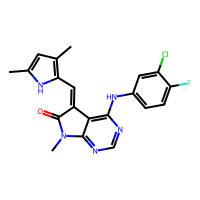
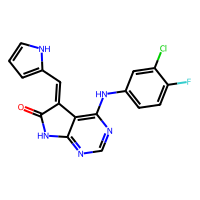
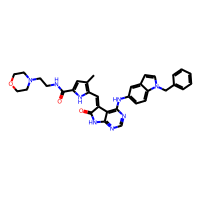
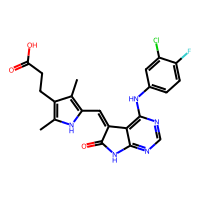
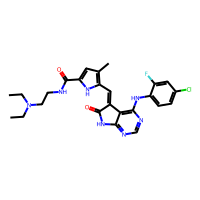

In [ ]:
# Imprimir la tabla tabla_CHEMBL674637
tabla_CHEMBL674637

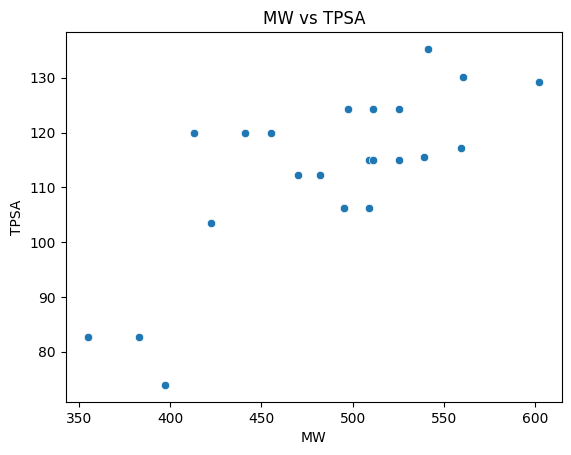

In [ ]:
import seaborn as sns
sns.scatterplot(x='MW', y='TPSA', data=tabla_CHEMBL674637, palette=["b", "r", "g"])
plt.xlabel('MW')
plt.ylabel('TPSA')
plt.title('MW vs TPSA')
plt.show()

## Visualización de los compuestos en cada cluster
Vamos a generar una tabla individual para cada cluster

In [ ]:
tabla_CHEMBL674637_cluster_0 = tabla_CHEMBL674637.loc[tabla_CHEMBL674637['Cluster_PCA'] == 0]
tabla_CHEMBL674637_cluster_1 = tabla_CHEMBL674637.loc[tabla_CHEMBL674637['Cluster_PCA'] == 1]
tabla_CHEMBL674637_cluster_2 = tabla_CHEMBL674637.loc[tabla_CHEMBL674637['Cluster_PCA'] == 2]
tabla_CHEMBL674637_cluster_3 = tabla_CHEMBL674637.loc[tabla_CHEMBL674637['Cluster_PCA'] == 3]
tabla_CHEMBL674637_cluster_4 = tabla_CHEMBL674637.loc[tabla_CHEMBL674637['Cluster_PCA'] == 4]
tabla_CHEMBL674637_cluster_5 = tabla_CHEMBL674637.loc[tabla_CHEMBL674637['Cluster_PCA'] == 5]

## Actividad N°2

Comparar en que clusters se encuentran las moléculas 10 y 21 entre el clustering realizado por Fingerprints y el clustering realizado por PCA

❗ Escribí los comandos necesarios en la celda que se encuentra debajo

👇

ID                                             smiles  \
0    0  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   
1    1  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
2    2  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...   
3    3  CCN(CC)CC(O)CNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc...   
4    4  O=C1Nc2ncnc(Nc3ccc(F)c(Cl)c3)c2/C1=C/c1ccc(C(=...   
5    5  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
6    6  CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ncnc(...   
7    7  Cc1cc(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c32)...   
8    8  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
9    9  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncn...   
10  10  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
11  11  CCN1CCN(C(=O)c2cc(C)c(/C=C3\C(=O)Nc4ncnc(Nc5cc...   
12  12  Cc1cc(C(=O)O)[nH]c1/C=C1\C(=O)Nc2ncnc(Nc3ccc(F...   
13  13  Cc1cc(CCC(=O)O)[nH]c1/C=C1\C(=O)Nc2ncnc(Nc3ccc...   
14  14  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
15  15  Cc1cc(C(=O)N2CCN(C)CC2)[nH]c1/C=C1\C(=O)Nc2ncn...   
16  16  C#Cc1cccc(Nc2ncnc3c2/C(=C/c2[nH]c(C(=O)NCCN4CC...   
17  17  CCN(CC)CCNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4...   
18  18  Cc1c(C(=O)N2CCN(C)CC2)c[nH]c1/C=C1\C(=O)Nc2ncn...   
19  19  Cc1cc(C(=O)N2CC(C)NC(C)C2)[nH]c1/C=C1\C(=O)Nc2...   
20  20  Cc1cc(C)c(/C=C2\C(=O)N(C)c3ncnc(Nc4ccc(F)c(Cl)...   
21  21    O=C1Nc2ncnc(Nc3ccc(F)c(Cl)c3)c2/C1=C/c1ccc[nH]1   
22  22  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncn...   
23  23  Cc1[nH]c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c...   
24  24  CCN(CC)CCNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4...   

                                               ROMol  Cluster_fingerprints  \
0   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5b60>                     0   
1   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5d20>                     1   
2   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5f50>                     1   
3   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5d90>                     1   
4   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad5fc0>                     1   
5   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6030>                     2   
6   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad60a0>                     0   
7   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6110>                     1   
8   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6180>                     1   
9   <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad61f0>                     1   
10  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6260>                     2   
11  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad62d0>                     1   
12  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6340>                     0   
13  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad63b0>                     0   
14  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6420>                     2   
15  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6490>                     1   
16  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6500>                     1   
17  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6570>                     1   
18  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad65e0>                     0   
19  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6650>                     1   
20  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad66c0>                     0   
21  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6730>                     0   
22  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad67a0>                     2   
23  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6810>                     0   
24  <rdkit.Chem.rdchem.Mol object at 0x7f92c3ad6880>                     1   

            MW    TPSA  nRotB  HBD  HBA     logP  Cluster_PCA  
0   383.094916   82.70    3.0  3.0  4.0  4.45034            3  
1   482.126944  112.24    4.0  3.0  6.0  3.61432            2  
2   539.184794  115.48    7.0  3.0  7.0  3.22822            1  
3   541.200444  135.27   10.0  5.0  7.0  3.57442            5  
4   511.153493  124.27    7.0  4.0  7.0  2.89550            1  
5   
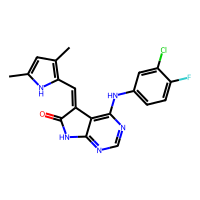
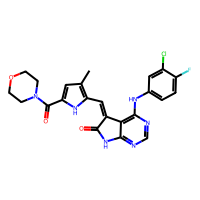
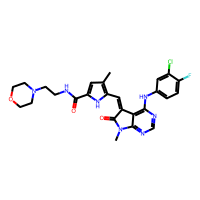
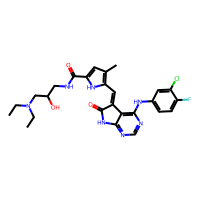
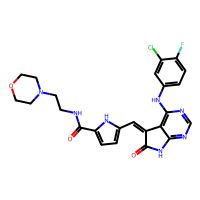
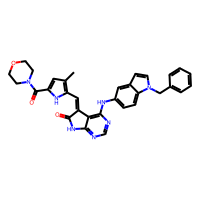
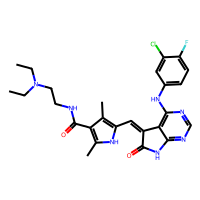
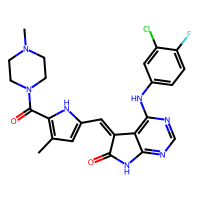
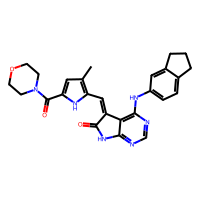
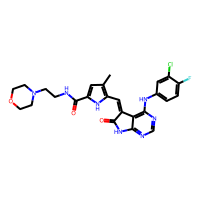
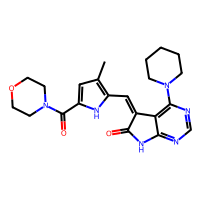
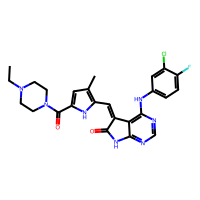
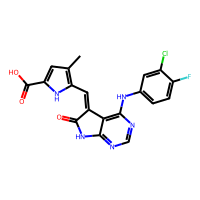
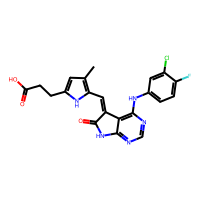
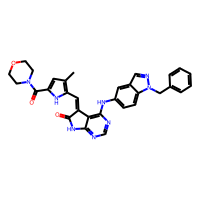
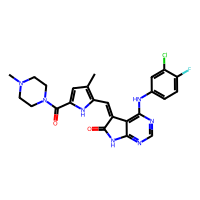
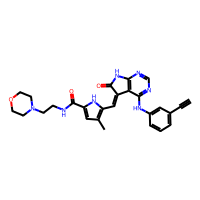
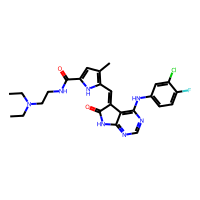
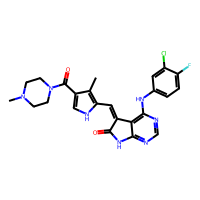
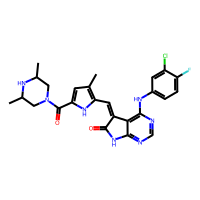
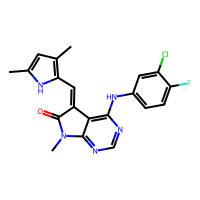
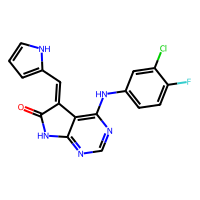
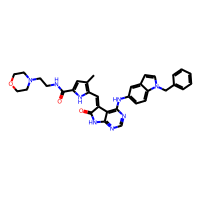
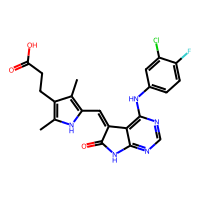
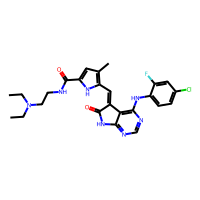

In [ ]:
tabla_CHEMBL674637

# Ejercicio Integrador

En el ejercicio integrador N°4 del trabajo práctico N°3 recolectamos los datos de moléculas ensayadas contra el Cáncer de Pulmón. Para hacerlo, usamos la función new_client() y drug_indication() que recolecta moléculas que contengan referencias de haber sido indicadas contra una enfermedad.

La actividad consiste en realizar la clusterización por Fingerprints de este set de datos.

Pista: En la celda que se encuentra debajo está el código para la obtención de los datos. La recolección de los datos puede tomar unos minutos!

In [ ]:
#@title Recolección de los datos
# Filtrar las indicaciones de medicamentos relacionadas con "LUNG CARCINOMA" y seleccionar solo la columna 'molecule_chembl_id'
datos_lung_cancer = new_client.drug_indication.filter(efo_term__icontains="LUNG CARCINOMA").only(['molecule_chembl_id'])

# Convertir los datos en un DataFrame
tabla_lung_cancer = pd.DataFrame.from_dict(datos_lung_cancer)

# Eliminar filas duplicadas en la tabla
tabla_lung_cancer = tabla_lung_cancer.drop_duplicates()

# Crear una lista para almacenar los SMILES
smiles_list = []

# Iterar sobre las filas de la tabla
for i in range(len(tabla_lung_cancer)):
  try:
    # Obtener la estructura de la molécula utilizando el ChEMBL ID
    mol = new_client.molecule.filter(chembl_id=tabla_lung_cancer['molecule_chembl_id'][i]).only(['molecule_structures'])
    try:
      # Obtener el SMILES canónico de la molécula
      smiles = mol[0]['molecule_structures']['canonical_smiles']
      smiles_list.append(smiles)
    except:
      # Si no se puede obtener el SMILES, agregar NA
      smiles_list.append(np.nan)
  except:
    # Si no se puede obtener la molécula, agregar NA
    smiles_list.append(np.nan)

# Agregar una columna 'smiles' a la tabla con los SMILES obtenidos
tabla_lung_cancer['smiles'] = smiles_list

# Eliminar filas con valores faltantes y reindexar las filas de forma consecutiva
tabla_lung_cancer = tabla_lung_cancer.dropna().reset_index(drop=True)

# Agrego la lista de indices
ID = range(0,398)
tabla_lung_cancer['ID'] = ID

# Agregar una columna de moléculas a la tabla utilizando la columna 'smiles'
PandasTools.AddMoleculeColumnToFrame(tabla_lung_cancer, smilesCol='smiles')


molecule_chembl_id                                             smiles  \
0        CHEMBL2105712  CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2...   
1           CHEMBL1471  C[C@@H](O[C@H]1OCCN(Cc2n[nH]c(=O)[nH]2)[C@H]1c...   
2           CHEMBL1023   C=C(c1ccc(C(=O)O)cc1)c1cc2c(cc1C)C(C)(C)CCC2(C)C   
3        CHEMBL1201748  CO[C@H]1C(=O)[C@]2(C)[C@@H](OC)C[C@H]3OC[C@@]3...   
4            CHEMBL846  C=C1/C(=C\C=C2/CCC[C@]3(C)[C@@H]([C@H](C)CCCC(...   
..                 ...                                                ...   
393      CHEMBL5077861  CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...   
394      CHEMBL5095362  Cc1ccc(-c2nc(N)nc3c2nnn3Cc2cccc(CO[C@H]3CCOC3)...   
395      CHEMBL5095364  CNC(=O)c1ccc(-c2cnc3ncc(Cc4ccc5ncccc5c4)n3n2)c...   
396      CHEMBL5095383  CN[C@@H](C)C(=O)N[C@H]1CN(C(=O)CC(C)C)CC[C@H]2...   
397      CHEMBL5095384  CCCCCCOC(C)c1c(C)c2cc3nc(c4c5[nH]c(cc6nc(cc1[n...   

      ID                                             ROMol  
0      0  <rdkit.Chem.rdchem.Mol object at 0x7f92bc9caab0>  
1      1  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b8a50>  
2      2  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b87b0>  
3      3  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b8900>  
4      4  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b85f0>  
..   ...                                               ...  
393  393  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf4c0>  
394  394  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf530>  
395  395  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf5a0>  
396  396  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf610>  
397  397  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf680>  

[398 rows x 4 columns]
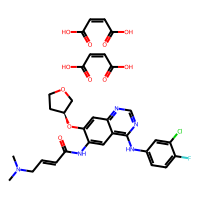
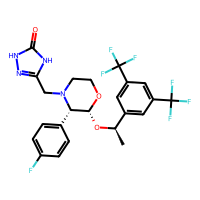
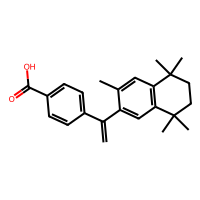
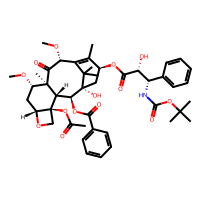
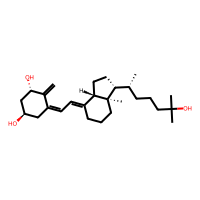
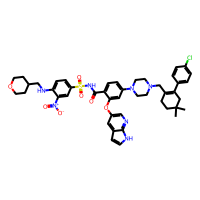
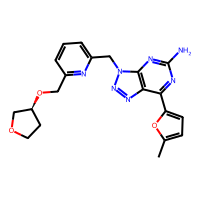
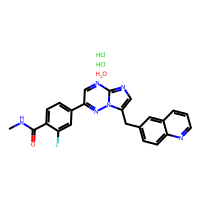
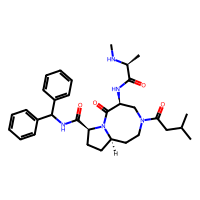
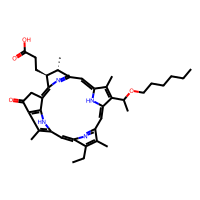

In [ ]:
# Imprimir la tabla con los resultados de drogas ensayadas contra Cáncer de pulmón
tabla_lung_cancer

## Actividad
1.  Calcular la Fingerprints de las moléculas
2.  Calcular la similitud de las moléculas
3.  Hace la clusterización con Fingerprints
4.  Genera el dendograma y el heatmap de la clusterización
5.  Generá histogramas para ver la distribución de las propiedades fisicoquímicas de las moléculas de cada cluster

❗ Escribí los comandos necesarios en la celda que se encuentra debajo

👇

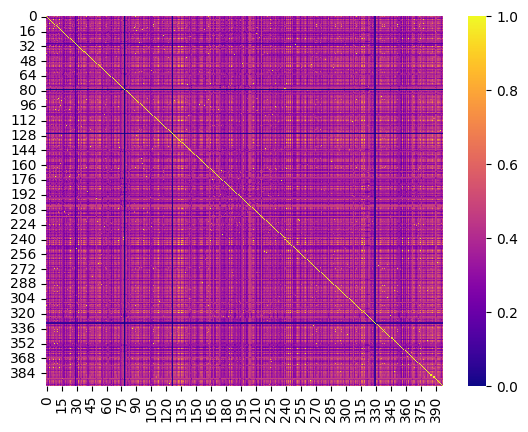

True


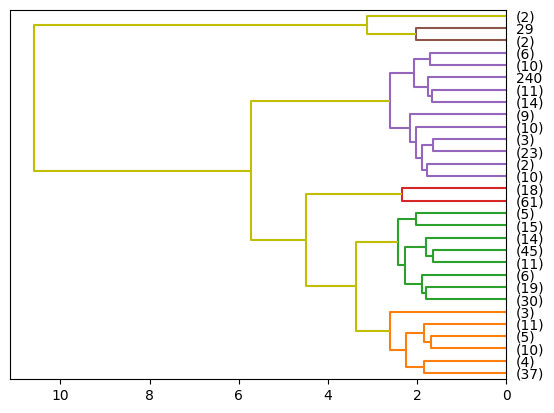

In [ ]:
fps = [FingerprintMols.FingerprintMol(mol) for mol in tabla_lung_cancer['ROMol']]
vector = np.array(fps[0])


# Configurar el manejo de advertencias
warnings.filterwarnings('ignore')

# Obtener el tamaño de la tabla 'tabla_lung_cancer'
size = len(tabla_lung_cancer)

# Crear un arreglo vacío para almacenar la matriz de similitud
hmap = np.empty(shape=(size, size))

# Crear un DataFrame vacío
table = pd.DataFrame()

# Iterar sobre las filas de la tabla
for i in range(len(tabla_lung_cancer)):
    # Iterar sobre las columnas de la tabla
    for j in range(len(tabla_lung_cancer)):
        # Calcular la similitud de huellas moleculares entre fps[i] y fps[j]
        similarity = DataStructs.FingerprintSimilarity(fps[i], fps[j])
        # Almacenar la similitud en la matriz hmap
        hmap[i, j] = similarity
        # Agregar la similitud al DataFrame 'table' con los índices correspondientes
        table.loc[tabla_lung_cancer['ID'][i], tabla_lung_cancer['ID'][j]] = similarity

heatmap = sns.heatmap(data=table,cmap='plasma')

# Mostrar el gráfico
plt.show()

linked = linkage(hmap, 'complete')

# Verifica la validez de la matriz
print(is_valid_linkage(linked))

# Crear una lista de etiquetas 'labelList' para las moléculas en la tabla 'tabla_lung_cancer'
labelList = [tabla_lung_cancer['ID'][i] for i in range(len(tabla_lung_cancer))]

# Generar el dendrograma
o = dendrogram(linked, color_threshold = 3, truncate_mode = "lastp", orientation='left', labels=labelList, distance_sort='descending', show_leaf_counts=True,  above_threshold_color='y')

In [ ]:
tabla_lung_cancer_copy = tabla_lung_cancer.copy()

In [ ]:

n = 6

# Obtener los clusters utilizando cut_tree con un número específico de clusters
clusters = cut_tree(linked, n)

# Agregar el número de cluster a la tabla
tabla_lung_cancer['Cluster_fingerprints'] = clusters.flatten()
tabla_lung_cancer



molecule_chembl_id                                             smiles  \
0        CHEMBL2105712  CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2...   
1           CHEMBL1471  C[C@@H](O[C@H]1OCCN(Cc2n[nH]c(=O)[nH]2)[C@H]1c...   
2           CHEMBL1023   C=C(c1ccc(C(=O)O)cc1)c1cc2c(cc1C)C(C)(C)CCC2(C)C   
3        CHEMBL1201748  CO[C@H]1C(=O)[C@]2(C)[C@@H](OC)C[C@H]3OC[C@@]3...   
4            CHEMBL846  C=C1/C(=C\C=C2/CCC[C@]3(C)[C@@H]([C@H](C)CCCC(...   
..                 ...                                                ...   
393      CHEMBL5077861  CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...   
394      CHEMBL5095362  Cc1ccc(-c2nc(N)nc3c2nnn3Cc2cccc(CO[C@H]3CCOC3)...   
395      CHEMBL5095364  CNC(=O)c1ccc(-c2cnc3ncc(Cc4ccc5ncccc5c4)n3n2)c...   
396      CHEMBL5095383  CN[C@@H](C)C(=O)N[C@H]1CN(C(=O)CC(C)C)CC[C@H]2...   
397      CHEMBL5095384  CCCCCCOC(C)c1c(C)c2cc3nc(c4c5[nH]c(cc6nc(cc1[n...   

      ID                                             ROMol          MW  \
0      0  <rdkit.Chem.rdchem.Mol object at 0x7f92bc9caab0>  717.184913   
1      1  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b8a50>  534.150188   
2      2  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b87b0>  348.208930   
3      3  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b8900>  835.377906   
4      4  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b85f0>  416.329045   
..   ...                                               ...         ...   
393  393  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf4c0>  867.318096   
394  394  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf530>  407.170588   
395  395  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf5a0>  502.108707   
396  396  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf610>  561.331505   
397  397  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf680>  636.367556   

       TPSA  nRotB  HBD   HBA     logP  Cluster_fingerprints  
0    237.81   12.0  6.0  11.0  3.81350                     0  
1     83.24    6.0  2.0   5.0  4.95210                     0  
2     37.30    3.0  1.0   1.0  6.10372                     1  
3    202.45   10.0  3.0  14.0  4.56780                     2  
4     60.69    6.0  3.0   3.0  5.70470                     0  
..      ...    ...  ...   ...      ...                   ...  
393  172.03   13.0  3.0  11.0  8.65990                     2  
394  127.00    6.0  1.0  10.0  2.12072                     2  
395  116.57    4.0  1.0   6.0  3.44790                     0  
396  110.85    9.0  3.0   5.0  2.62290                     1  
397  120.96   11.0  3.0   5.0  9.42114                     2  

[398 rows x 11 columns]

In [ ]:
for i in range(len(tabla_lung_cancer)):
    mol = tabla_lung_cancer['ROMol'][i]

    # Calcular el peso molecular exacto
    tabla_lung_cancer.loc[i, 'MW'] = Descriptors.ExactMolWt(mol)

    # Calcular el área de superficie polar topológica (TPSA)
    tabla_lung_cancer.loc[i, 'TPSA'] = Chem.rdMolDescriptors.CalcTPSA(mol)

    # Calcular el número de enlaces rotativos (nRotB)
    tabla_lung_cancer.loc[i, 'nRotB'] = Descriptors.NumRotatableBonds(mol)

    # Calcular el número de donantes de enlaces de hidrógeno (HBD)
    tabla_lung_cancer.loc[i, 'HBD'] = Descriptors.NumHDonors(mol)

    # Calcular el número de aceptores de enlaces de hidrógeno (HBA)
    tabla_lung_cancer.loc[i, 'HBA'] = Descriptors.NumHAcceptors(mol)

    # Calcular el logaritmo del coeficiente de partición octanol-agua (logP)
    tabla_lung_cancer.loc[i, 'logP'] = Descriptors.MolLogP(mol)

descriptors = tabla_lung_cancer.loc[:, ['MW', 'TPSA', 'nRotB', 'HBD','HBA', 'logP']].values

# Paso 2: Normalizar los descriptores utilizando StandardScaler
descriptors_std = StandardScaler().fit_transform(descriptors)

# Paso 3: Aplicar PCA a los descriptores normalizados
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)

# Formateo de datos
# Crear un DataFrame con las coordenadas PCA
descriptors_pca = pd.DataFrame(descriptors_2d)

# Establecer el índice del DataFrame como el índice de la tabla CHEMBL674637
descriptors_pca.index = tabla_lung_cancer.index

# Etiquetar las columnas del DataFrame como PC1, PC2, PC3, etc.
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]



molecule_chembl_id                                             smiles  \
0        CHEMBL2105712  CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2...   
1           CHEMBL1471  C[C@@H](O[C@H]1OCCN(Cc2n[nH]c(=O)[nH]2)[C@H]1c...   
2           CHEMBL1023   C=C(c1ccc(C(=O)O)cc1)c1cc2c(cc1C)C(C)(C)CCC2(C)C   
3        CHEMBL1201748  CO[C@H]1C(=O)[C@]2(C)[C@@H](OC)C[C@H]3OC[C@@]3...   
4            CHEMBL846  C=C1/C(=C\C=C2/CCC[C@]3(C)[C@@H]([C@H](C)CCCC(...   
..                 ...                                                ...   
393      CHEMBL5077861  CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...   
394      CHEMBL5095362  Cc1ccc(-c2nc(N)nc3c2nnn3Cc2cccc(CO[C@H]3CCOC3)...   
395      CHEMBL5095364  CNC(=O)c1ccc(-c2cnc3ncc(Cc4ccc5ncccc5c4)n3n2)c...   
396      CHEMBL5095383  CN[C@@H](C)C(=O)N[C@H]1CN(C(=O)CC(C)C)CC[C@H]2...   
397      CHEMBL5095384  CCCCCCOC(C)c1c(C)c2cc3nc(c4c5[nH]c(cc6nc(cc1[n...   

      ID                                             ROMol          MW  \
0      0  <rdkit.Chem.rdchem.Mol object at 0x7f92bc9caab0>  717.184913   
1      1  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b8a50>  534.150188   
2      2  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b87b0>  348.208930   
3      3  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b8900>  835.377906   
4      4  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b85f0>  416.329045   
..   ...                                               ...         ...   
393  393  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf4c0>  867.318096   
394  394  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf530>  407.170588   
395  395  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf5a0>  502.108707   
396  396  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf610>  561.331505   
397  397  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf680>  636.367556   

       TPSA  nRotB  HBD   HBA     logP  
0    237.81   12.0  6.0  11.0  3.81350  
1     83.24    6.0  2.0   5.0  4.95210  
2     37.30    3.0  1.0   1.0  6.10372  
3    202.45   10.0  3.0  14.0  4.56780  
4     60.69    6.0  3.0   3.0  5.70470  
..      ...    ...  ...   ...      ...  
393  172.03   13.0  3.0  11.0  8.65990  
394  127.00    6.0  1.0  10.0  2.12072  
395  116.57    4.0  1.0   6.0  3.44790  
396  110.85    9.0  3.0   5.0  2.62290  
397  120.96   11.0  3.0   5.0  9.42114  

[398 rows x 10 columns]
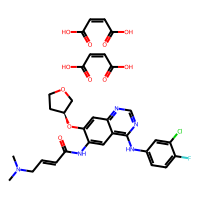
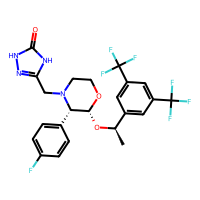
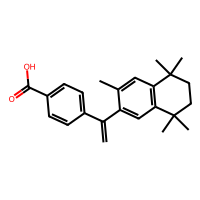
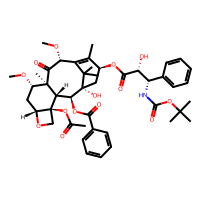
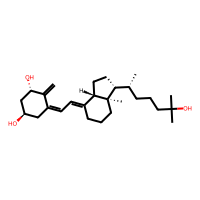
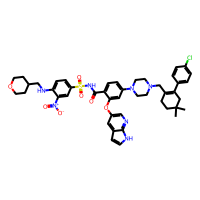
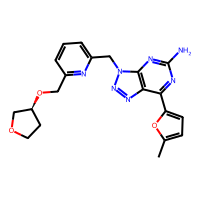
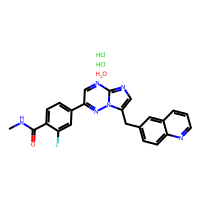
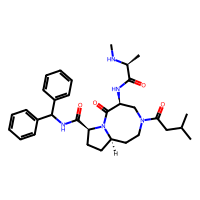
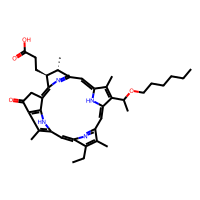

In [ ]:
tabla_lung_cancer

In [ ]:
tabla_lung_cancer.loc[:, ["molecule_chembl_id", 'MW', 'TPSA', 'nRotB', 'HBD','HBA', 'logP']]

molecule_chembl_id          MW    TPSA  nRotB  HBD   HBA     logP
0        CHEMBL2105712  717.184913  237.81   12.0  6.0  11.0  3.81350
1           CHEMBL1471  534.150188   83.24    6.0  2.0   5.0  4.95210
2           CHEMBL1023  348.208930   37.30    3.0  1.0   1.0  6.10372
3        CHEMBL1201748  835.377906  202.45   10.0  3.0  14.0  4.56780
4            CHEMBL846  416.329045   60.69    6.0  3.0   3.0  5.70470
..                 ...         ...     ...    ...  ...   ...      ...
393      CHEMBL5077861  867.318096  172.03   13.0  3.0  11.0  8.65990
394      CHEMBL5095362  407.170588  127.00    6.0  1.0  10.0  2.12072
395      CHEMBL5095364  502.108707  116.57    4.0  1.0   6.0  3.44790
396      CHEMBL5095383  561.331505  110.85    9.0  3.0   5.0  2.62290
397      CHEMBL5095384  636.367556  120.96   11.0  3.0   5.0  9.42114

[398 rows x 7 columns]

In [ ]:
descriptors_pca

PC1       PC2       PC3       PC4       PC5       PC6
0    1.088191  0.765161  0.122986  0.226437 -0.062202  0.139615
1   -0.446046  0.154383  0.342426  0.033446  0.149719 -0.047449
2   -1.196697  0.135124  0.245441 -0.015409  0.137770  0.026636
3    0.793008  0.141744  0.760008  0.342860 -0.057966  0.069218
4   -0.644706  0.481940  0.122684 -0.022944  0.075916 -0.114305
..        ...       ...       ...       ...       ...       ...
393  0.479892  0.750037  1.261268  0.206056 -0.010292  0.067838
394 -0.163048 -0.456942  0.149748 -0.066025 -0.247585  0.110771
395 -0.430836 -0.268487  0.241451  0.105608  0.114586  0.160819
396  0.029864  0.174319  0.067985 -0.209609  0.238209 -0.046974
397 -0.238538  0.960264  0.924392  0.031901  0.040627  0.107339

[398 rows x 6 columns]

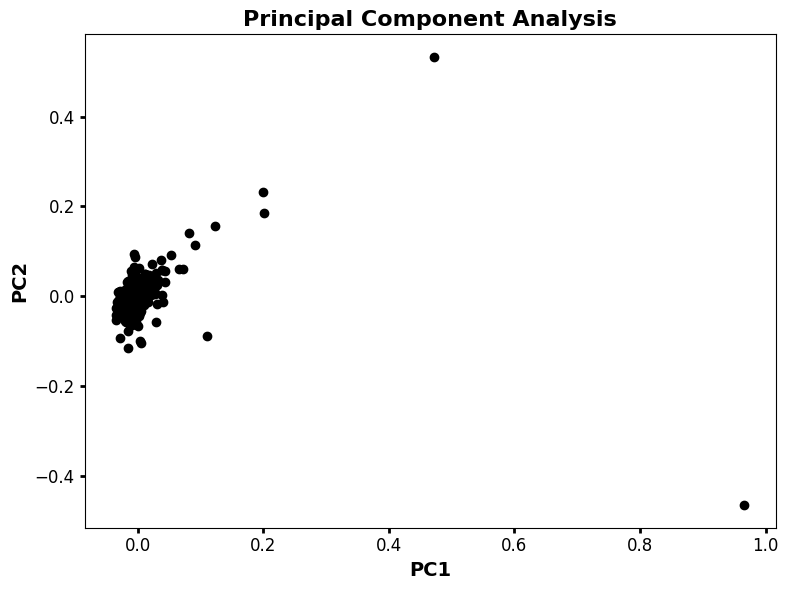

In [ ]:
#@title Gráfico de PCA normalizado
# Calculamos la escala para normalizar las componentes principales
scale1 = 1.0 / (max(descriptors_pca['PC1']) - min(descriptors_pca['PC1']))
scale2 = 1.0 / (max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))

# Normalizamos las componentes principales y las almacenamos en nuevas columnas
descriptors_pca['PC1_normalized'] = [i * scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized'] = [i * scale2 for i in descriptors_pca['PC2']]

# Crear una nueva figura con tamaño de 8x6 pulgadas
fig = plt.figure(figsize=(8, 6))

# Agregar un único subplot en la figura
ax = fig.add_subplot(111)

# Graficar las componentes principales normalizadas
ax.plot(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'], 'o', color='k')

# Establecer el título del gráfico
ax.set_title('Principal Component Analysis', fontsize=16, fontweight='bold', family='sans-serif')

# Etiquetar el eje x
ax.set_xlabel('PC1', fontsize=14, fontweight='bold')

# Etiquetar el eje y
ax.set_ylabel('PC2', fontsize=14, fontweight='bold')

# Configurar los parámetros de las marcas en los ejes
plt.tick_params('both', width=2, labelsize=12)

# Ajustar el diseño del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Para n_clusters = 2 El coeficiente de silueta promedio es: 0.9548383379930927
Para n_clusters = 3 El coeficiente de silueta promedio es: 0.8850484873679999
Para n_clusters = 4 El coeficiente de silueta promedio es: 0.5962546253806492
Para n_clusters = 5 El coeficiente de silueta promedio es: 0.40365062961809767
Para n_clusters = 6 El coeficiente de silueta promedio es: 0.3862654365483415
Para n_clusters = 7 El coeficiente de silueta promedio es: 0.35333115918761654
Para n_clusters = 8 El coeficiente de silueta promedio es: 0.3570478267449158
Para n_clusters = 9 El coeficiente de silueta promedio es: 0.3580761032690965
Para n_clusters = 10 El coeficiente de silueta promedio es: 0.3647698624851467


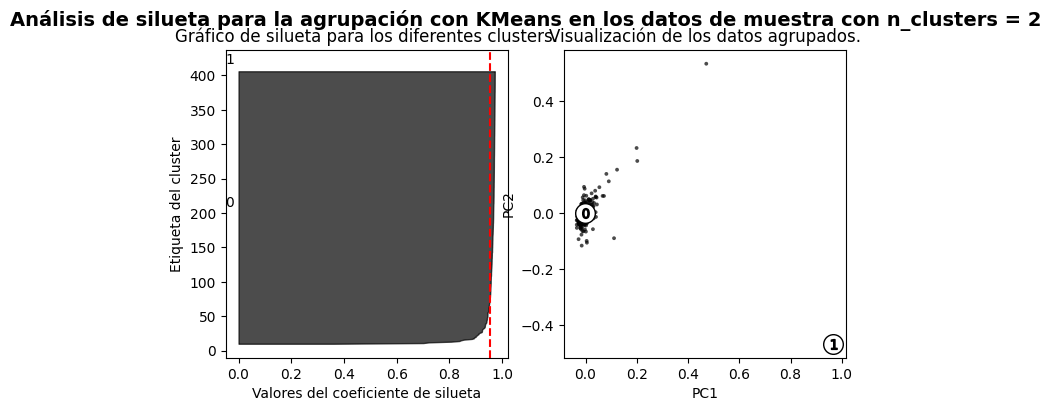

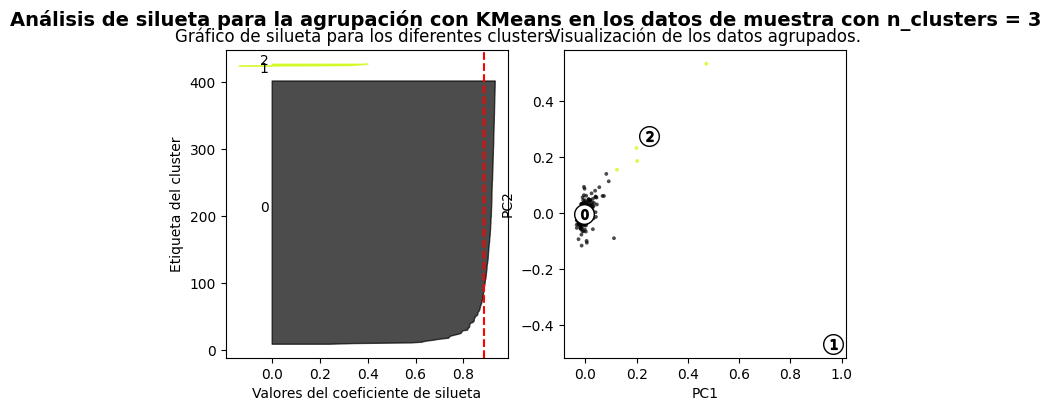

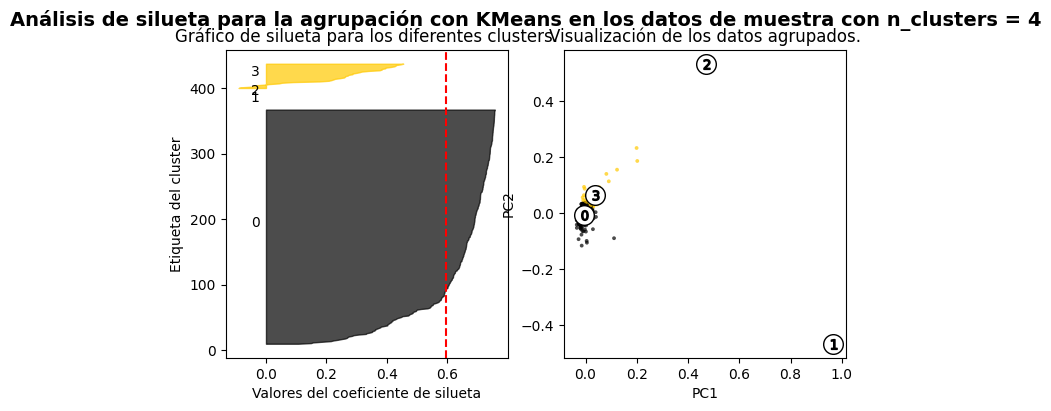

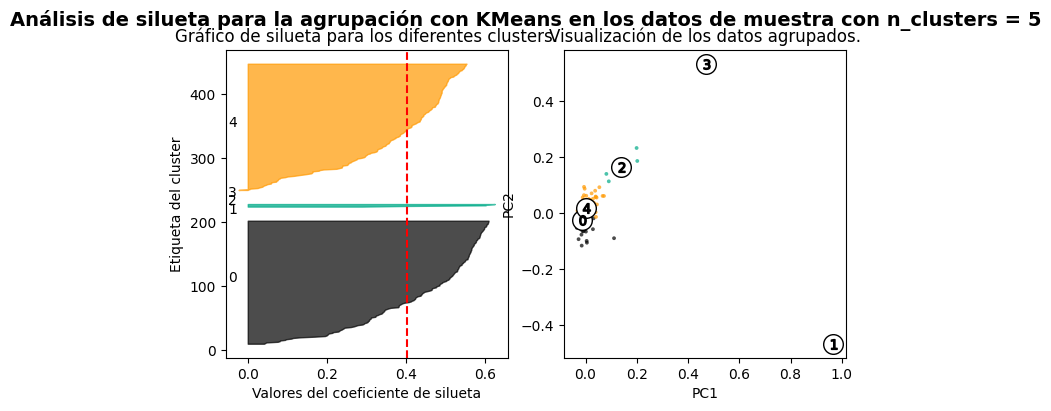

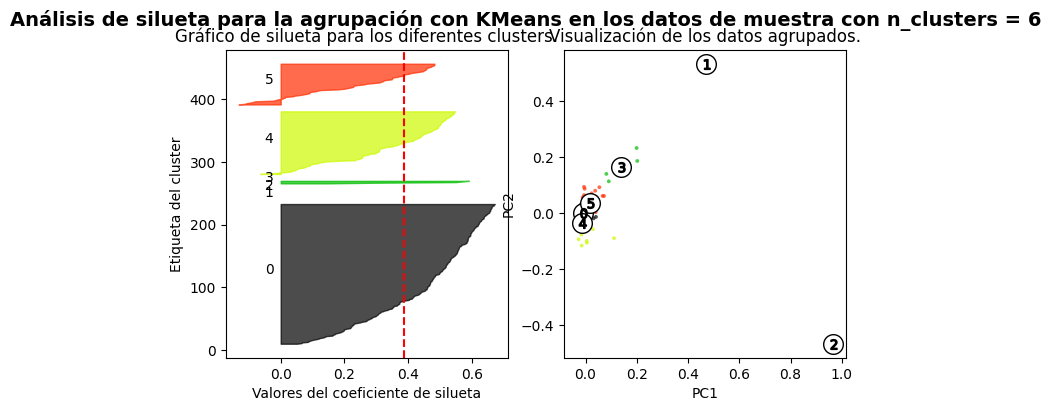

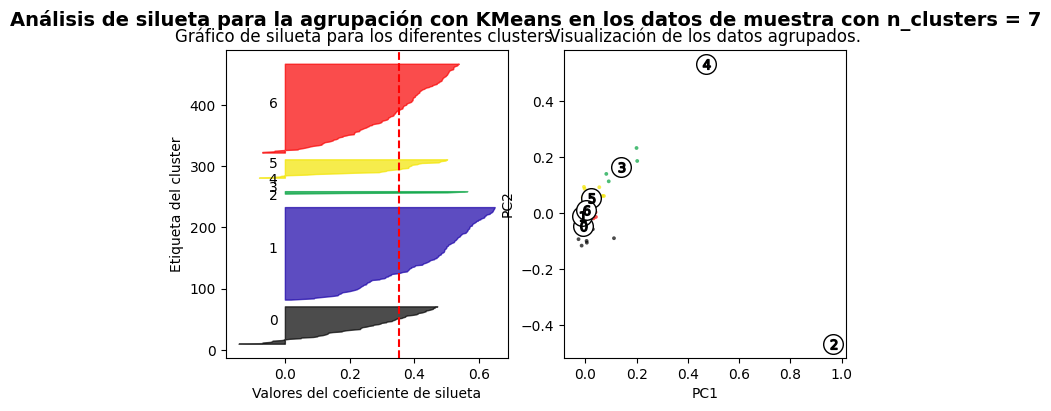

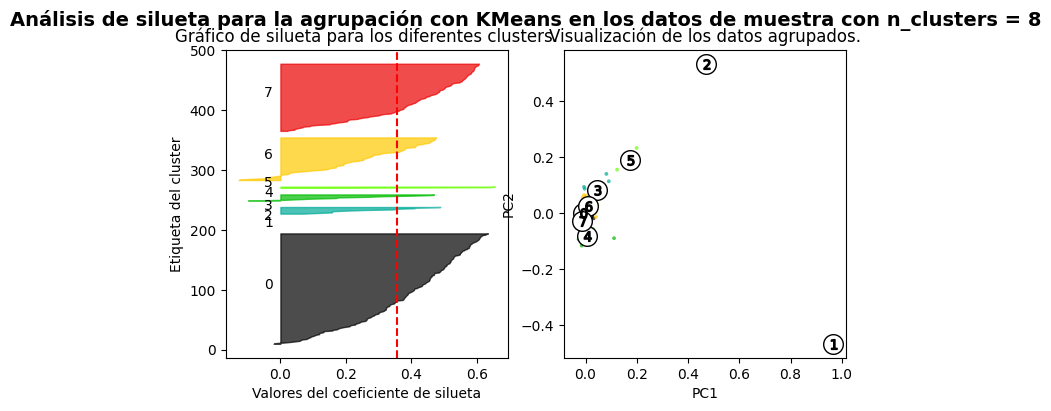

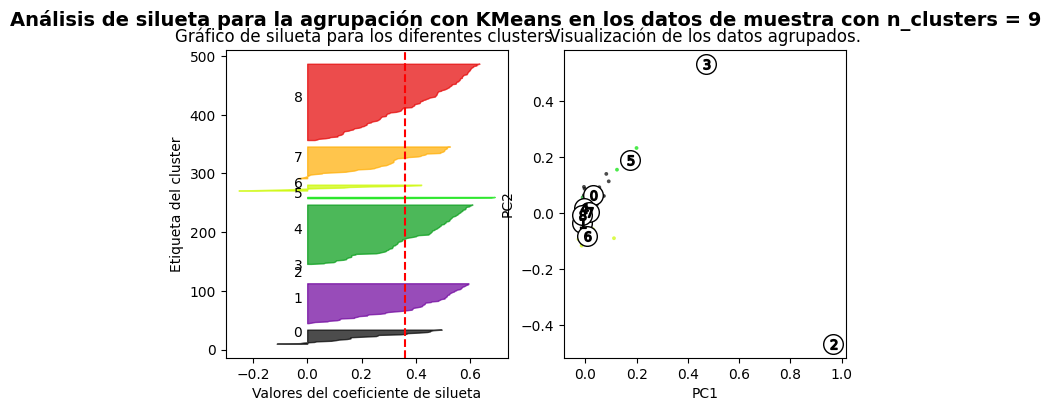

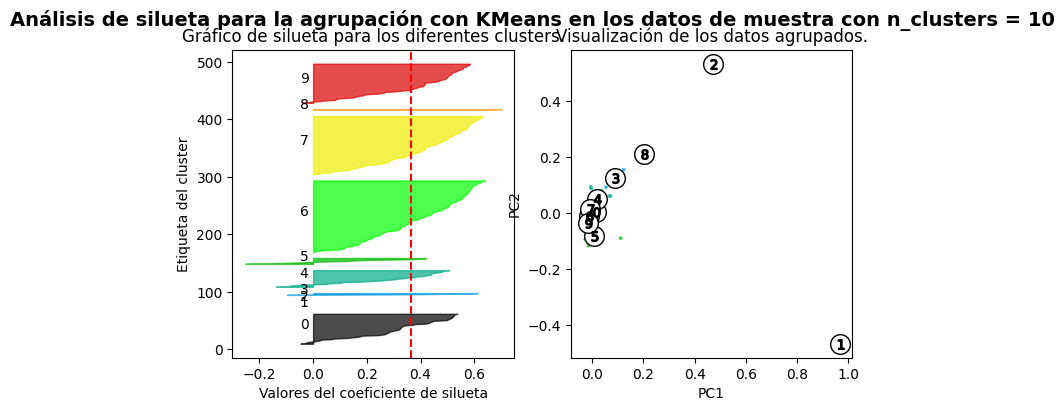

In [ ]:

#@title Evaluación del mejor número de clusters
# Realizamos el análisis de silueta para diferentes valores de K (número de clusters)
for n_clusters in range_K_clusters:
    warnings.filterwarnings('ignore', category=FutureWarning)
    # Creamos una figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)

    # Creamos una instancia del algoritmo KMeans con el número de clusters deseado
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)

    # Aplicamos el algoritmo a las componentes principales normalizadas
    cluster_labels = kmeans.fit_predict(descriptors_pca[['PC1_normalized', 'PC2_normalized']])

    # Calculamos el coeficiente de silueta promedio para evaluar la calidad de los clusters
    silhouette_avg = silhouette_score(descriptors_pca[['PC1_normalized', 'PC2_normalized']], cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El coeficiente de silueta promedio es:", silhouette_avg)

    # Calculamos los valores de silueta para cada muestra
    sample_silhouette_values = silhouette_samples(descriptors_pca[['PC1_normalized', 'PC2_normalized']], cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        # Agrupamos los valores de silueta para las muestras pertenecientes al cluster i y los ordenamos
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Definimos un color para el cluster i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Etiquetamos los gráficos de silueta con los números de cluster
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Calculamos el nuevo valor de y_lower para el próximo gráfico
        y_lower = y_upper + 10  # 10 para las muestras con valor 0

    # Configuramos el primer subplot (gráfico de silueta)
    ax1.set_title("Gráfico de silueta para los diferentes clusters.")
    ax1.set_xlabel("Valores del coeficiente de silueta")
    ax1.set_ylabel("Etiqueta del cluster")

    # Agregamos una línea vertical para el coeficiente de silueta promedio
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    # Configuramos el segundo subplot (visualización de los clusters)
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'],
                marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Etiquetamos los clusters
    centers = kmeans.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    # Iterar sobre los centroides de los clusters y graficarlos en el subplot ax2
    for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')
    # Configurar título y etiquetas de los ejes del subplot ax2
      ax2.set_title("Visualización de los datos agrupados.")
      ax2.set_xlabel("PC1")
      ax2.set_ylabel("PC2")

    # Configurar título principal de la figura con información del análisis de silueta
    plt.suptitle(("Análisis de silueta para la agrupación con KMeans en los datos de muestra con n_clusters = %d" % n_clusters),
                              fontsize=14, fontweight='bold')

# Mostrar la figura completa
plt.show()

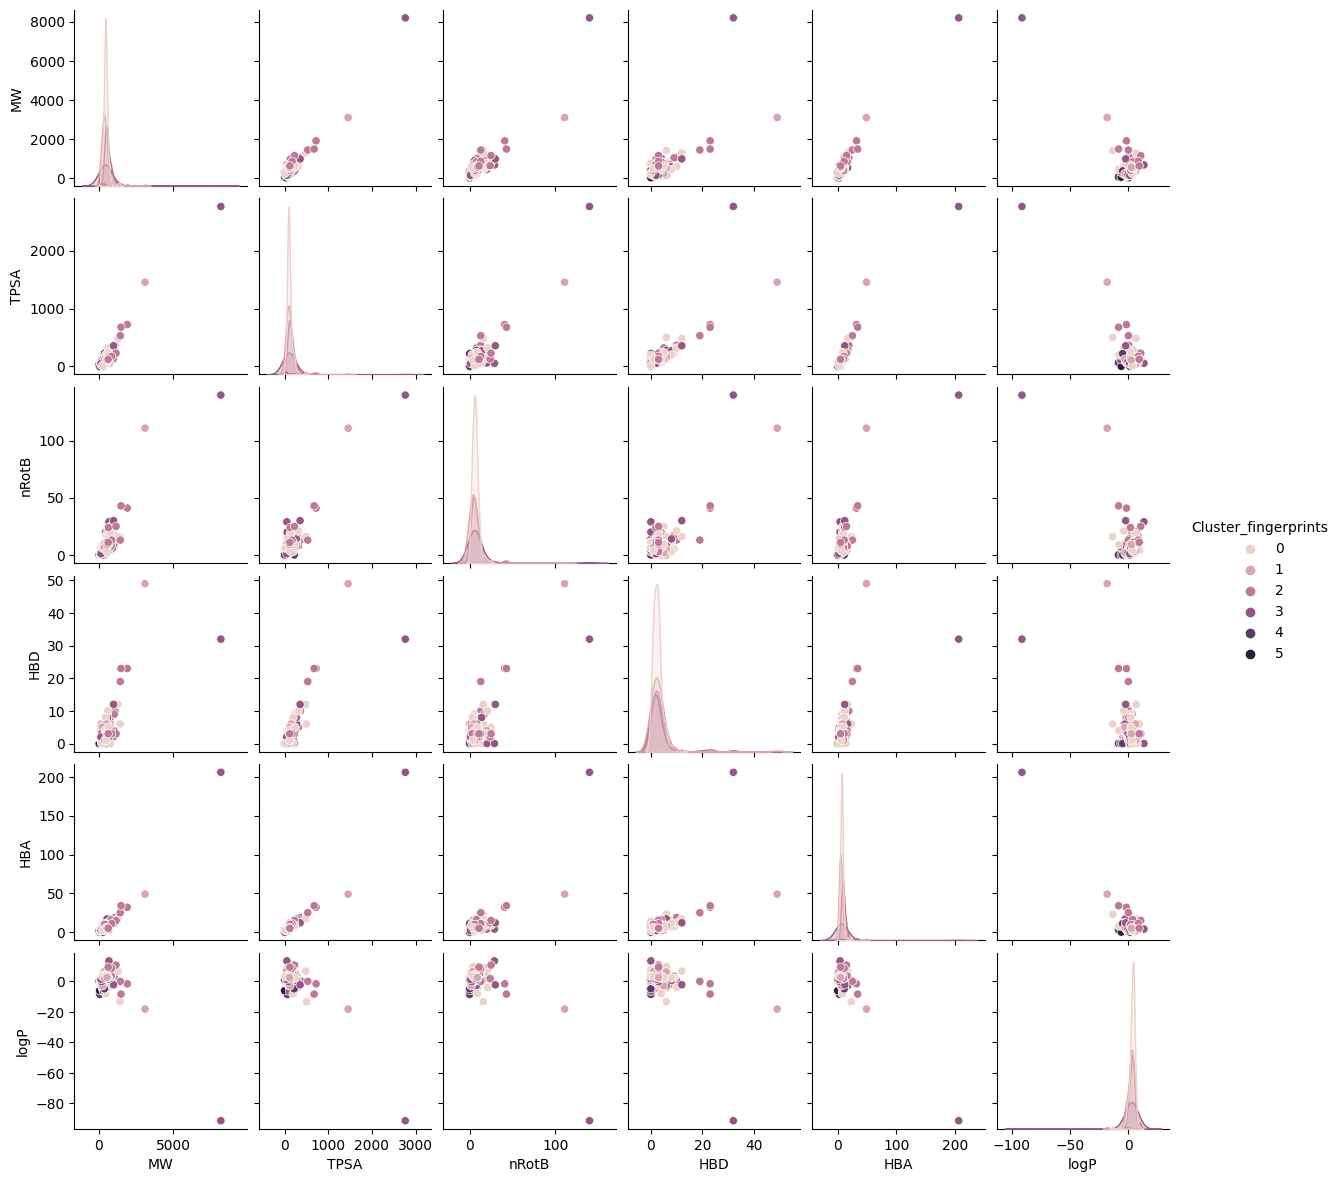

In [ ]:
sns.pairplot(tabla_lung_cancer.loc[:, ['MW', 'TPSA', 'nRotB', 'HBD','HBA', 'logP', "Cluster_fingerprints"]],hue="Cluster_fingerprints", height = 2)

In [ ]:
descriptors_pca["PC1"].sort_values()

75     -1.301089
330    -1.298247
126    -1.284327
251    -1.223241
179    -1.213647
         ...    
316     4.654066
132     7.542639
387     7.642884
65     17.838185
139    36.553644
Name: PC1, Length: 398, dtype: float64

In [ ]:
tabla_lung_cancer_cortada = tabla_lung_cancer.drop(139)
tabla_lung_cancer_cortada = tabla_lung_cancer_cortada.drop(65)

In [ ]:
tabla_lung_cancer_cortada.loc[: ,"ID"] = list(range(0,len(tabla_lung_cancer_cortada)))

In [ ]:
tabla_lung_cancer_cortada

index molecule_chembl_id  \
0        0      CHEMBL2105712   
1        1         CHEMBL1471   
2        2         CHEMBL1023   
3        3      CHEMBL1201748   
4        4          CHEMBL846   
..     ...                ...   
391    393      CHEMBL5077861   
392    394      CHEMBL5095362   
393    395      CHEMBL5095364   
394    396      CHEMBL5095383   
395    397      CHEMBL5095384   

                                                smiles   ID  \
0    CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2...    0   
1    C[C@@H](O[C@H]1OCCN(Cc2n[nH]c(=O)[nH]2)[C@H]1c...    1   
2     C=C(c1ccc(C(=O)O)cc1)c1cc2c(cc1C)C(C)(C)CCC2(C)C    2   
3    CO[C@H]1C(=O)[C@]2(C)[C@@H](OC)C[C@H]3OC[C@@]3...    3   
4    C=C1/C(=C\C=C2/CCC[C@]3(C)[C@@H]([C@H](C)CCCC(...    4   
..                                                 ...  ...   
391  CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...  391   
392  Cc1ccc(-c2nc(N)nc3c2nnn3Cc2cccc(CO[C@H]3CCOC3)...  392   
393  CNC(=O)c1ccc(-c2cnc3ncc(Cc4ccc5ncccc5c4)n3n2)c...  393   
394  CN[C@@H](C)C(=O)N[C@H]1CN(C(=O)CC(C)C)CC[C@H]2...  394   
395  CCCCCCOC(C)c1c(C)c2cc3nc(c4c5[nH]c(cc6nc(cc1[n...  395   

                                                ROMol          MW    TPSA  \
0    <rdkit.Chem.rdchem.Mol object at 0x7f92bc9caab0>  717.184913  237.81   
1    <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b8a50>  534.150188   83.24   
2    <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b87b0>  348.208930   37.30   
3    <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b8900>  835.377906  202.45   
4    <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b85f0>  416.329045   60.69   
..                                                ...         ...     ...   
391  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf4c0>  867.318096  172.03   
392  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf530>  407.170588  127.00   
393  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf5a0>  502.108707  116.57   
394  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf610>  561.331505  110.85   
395  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf680>  636.367556  120.96   

     nRotB  HBD   HBA     logP  Cluster_fingerprints  
0     12.0  6.0  11.0  3.81350                     0  
1      6.0  2.0   5.0  4.95210                     0  
2      3.0  1.0   1.0  6.10372                     1  
3     10.0  3.0  14.0  4.56780                     2  
4      6.0  3.0   3.0  5.70470                     0  
..     ...  ...   ...      ...                   ...  
391   13.0  3.0  11.0  8.65990                     2  
392    6.0  1.0  10.0  2.12072                     2  
393    4.0  1.0   6.0  3.44790                     0  
394    9.0  3.0   5.0  2.62290                     1  
395   11.0  3.0   5.0  9.42114                     2  

[396 rows x 12 columns]

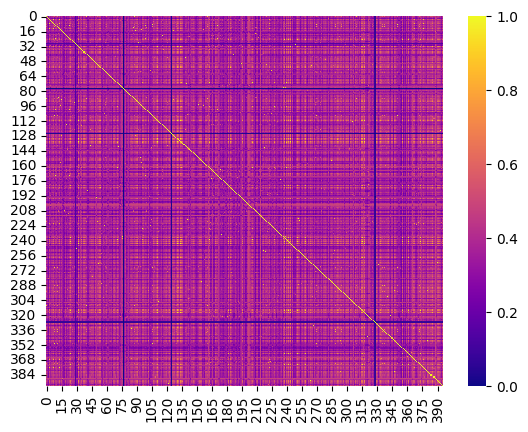

True


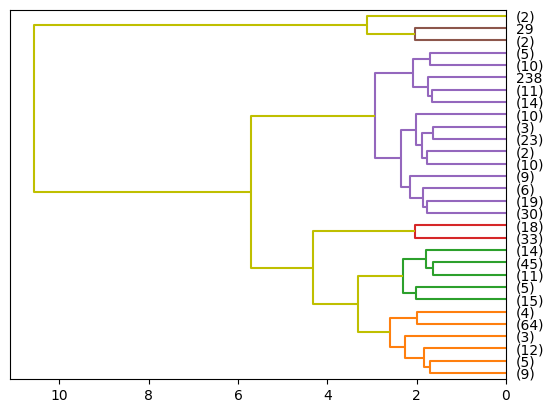

In [ ]:
fps = [FingerprintMols.FingerprintMol(mol) for mol in tabla_lung_cancer_cortada['ROMol']]
vector = np.array(fps[0])


# Configurar el manejo de advertencias
warnings.filterwarnings('ignore')

# Obtener el tamaño de la tabla 'tabla_lung_cancer_cortada'
size = len(tabla_lung_cancer_cortada)

# Crear un arreglo vacío para almacenar la matriz de similitud
hmap = np.empty(shape=(size, size))

# Crear un DataFrame vacío
table = pd.DataFrame()

# Iterar sobre las filas de la tabla
for i in range(len(tabla_lung_cancer_cortada)):
    # Iterar sobre las columnas de la tabla
    for j in range(len(tabla_lung_cancer_cortada)):
      # Calcular la similitud de huellas moleculares entre fps[i] y fps[j]
      similarity = DataStructs.FingerprintSimilarity(fps[i], fps[j])
      # Almacenar la similitud en la matriz hmap
      hmap[i, j] = similarity
      # Agregar la similitud al DataFrame 'table' con los índices correspondientes
      table.loc[tabla_lung_cancer_cortada['ID'][i], tabla_lung_cancer_cortada['ID'][j]] = similarity

heatmap = sns.heatmap(data=table,cmap='plasma')

# Mostrar el gráfico
plt.show()

linked = linkage(hmap, 'complete')

# Verifica la validez de la matriz
print(is_valid_linkage(linked))

# Crear una lista de etiquetas 'labelList' para las moléculas en la tabla 'tabla_lung_cancer_cortada'
labelList = [tabla_lung_cancer_cortada['ID'][i] for i in range(len(tabla_lung_cancer_cortada))]

# Generar el dendrograma
o = dendrogram(linked, color_threshold = 3, truncate_mode = "lastp", orientation='left', labels=labelList, distance_sort='descending', show_leaf_counts=True,  above_threshold_color='y')

In [ ]:
for i in range(len(tabla_lung_cancer_cortada)):
    mol = tabla_lung_cancer_cortada['ROMol'][i]

    # Calcular el peso molecular exacto
    tabla_lung_cancer_cortada.loc[i, 'MW'] = Descriptors.ExactMolWt(mol)

    # Calcular el área de superficie polar topológica (TPSA)
    tabla_lung_cancer_cortada.loc[i, 'TPSA'] = Chem.rdMolDescriptors.CalcTPSA(mol)

    # Calcular el número de enlaces rotativos (nRotB)
    tabla_lung_cancer_cortada.loc[i, 'nRotB'] = Descriptors.NumRotatableBonds(mol)

    # Calcular el número de donantes de enlaces de hidrógeno (HBD)
    tabla_lung_cancer_cortada.loc[i, 'HBD'] = Descriptors.NumHDonors(mol)

    # Calcular el número de aceptores de enlaces de hidrógeno (HBA)
    tabla_lung_cancer_cortada.loc[i, 'HBA'] = Descriptors.NumHAcceptors(mol)

    # Calcular el logaritmo del coeficiente de partición octanol-agua (logP)
    tabla_lung_cancer_cortada.loc[i, 'logP'] = Descriptors.MolLogP(mol)

descriptors = tabla_lung_cancer_cortada.loc[:, ['MW', 'TPSA', 'nRotB', 'HBD','HBA', 'logP']].values

# Paso 2: Normalizar los descriptores utilizando StandardScaler
descriptors_std = StandardScaler().fit_transform(descriptors)

# Paso 3: Aplicar PCA a los descriptores normalizados
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)

# Formateo de datos
# Crear un DataFrame con las coordenadas PCA
descriptors_pca = pd.DataFrame(descriptors_2d)

# Establecer el índice del DataFrame como el índice de la tabla CHEMBL674637
descriptors_pca.index = tabla_lung_cancer_cortada.index

# Etiquetar las columnas del DataFrame como PC1, PC2, PC3, etc.
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]

In [ ]:

n = 6

# Obtener los clusters utilizando cut_tree con un número específico de clusters
clusters = cut_tree(linked, n)

# Agregar el número de cluster a la tabla
tabla_lung_cancer_cortada['Cluster_fingerprints'] = clusters.flatten()
tabla_lung_cancer_cortada

index molecule_chembl_id  \
0        0      CHEMBL2105712   
1        1         CHEMBL1471   
2        2         CHEMBL1023   
3        3      CHEMBL1201748   
4        4          CHEMBL846   
..     ...                ...   
391    393      CHEMBL5077861   
392    394      CHEMBL5095362   
393    395      CHEMBL5095364   
394    396      CHEMBL5095383   
395    397      CHEMBL5095384   

                                                smiles   ID  \
0    CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2...    0   
1    C[C@@H](O[C@H]1OCCN(Cc2n[nH]c(=O)[nH]2)[C@H]1c...    1   
2     C=C(c1ccc(C(=O)O)cc1)c1cc2c(cc1C)C(C)(C)CCC2(C)C    2   
3    CO[C@H]1C(=O)[C@]2(C)[C@@H](OC)C[C@H]3OC[C@@]3...    3   
4    C=C1/C(=C\C=C2/CCC[C@]3(C)[C@@H]([C@H](C)CCCC(...    4   
..                                                 ...  ...   
391  CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...  391   
392  Cc1ccc(-c2nc(N)nc3c2nnn3Cc2cccc(CO[C@H]3CCOC3)...  392   
393  CNC(=O)c1ccc(-c2cnc3ncc(Cc4ccc5ncccc5c4)n3n2)c...  393   
394  CN[C@@H](C)C(=O)N[C@H]1CN(C(=O)CC(C)C)CC[C@H]2...  394   
395  CCCCCCOC(C)c1c(C)c2cc3nc(c4c5[nH]c(cc6nc(cc1[n...  395   

                                                ROMol          MW    TPSA  \
0    <rdkit.Chem.rdchem.Mol object at 0x7f92bc9caab0>  717.184913  237.81   
1    <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b8a50>  534.150188   83.24   
2    <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b87b0>  348.208930   37.30   
3    <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b8900>  835.377906  202.45   
4    <rdkit.Chem.rdchem.Mol object at 0x7f92bc8b85f0>  416.329045   60.69   
..                                                ...         ...     ...   
391  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf4c0>  867.318096  172.03   
392  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf530>  407.170588  127.00   
393  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf5a0>  502.108707  116.57   
394  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf610>  561.331505  110.85   
395  <rdkit.Chem.rdchem.Mol object at 0x7f92bc8cf680>  636.367556  120.96   

     nRotB  HBD   HBA     logP  Cluster_fingerprints  
0     12.0  6.0  11.0  3.81350                     0  
1      6.0  2.0   5.0  4.95210                     1  
2      3.0  1.0   1.0  6.10372                     1  
3     10.0  3.0  14.0  4.56780                     2  
4      6.0  3.0   3.0  5.70470                     1  
..     ...  ...   ...      ...                   ...  
391   13.0  3.0  11.0  8.65990                     2  
392    6.0  1.0  10.0  2.12072                     3  
393    4.0  1.0   6.0  3.44790                     0  
394    9.0  3.0   5.0  2.62290                     1  
395   11.0  3.0   5.0  9.42114                     2  

[396 rows x 12 columns]

In [ ]:
descriptors_pca

PC1       PC2       PC3       PC4       PC5       PC6
0    2.806437  0.373356  0.172583 -0.397149 -0.058821  0.324366
1   -0.469818  0.872441  0.043609 -0.218340  0.316756 -0.108545
2   -2.070560  0.985561  0.295618 -0.646676  0.287580  0.117921
3    2.500612  1.009145 -1.018761  0.497490 -0.054716  0.051135
4   -0.948641  0.887893  0.599581 -0.760792  0.081758 -0.141956
..        ...       ...       ...       ...       ...       ...
391  2.153308  2.543289 -0.321270  0.022220  0.027992  0.139085
392  0.036038 -0.209586 -0.533293  0.760264 -0.504542  0.216680
393 -0.498874  0.266718 -0.457821  0.117881  0.350064  0.269884
394  0.227369  0.240041  0.607884  0.055934  0.546893 -0.143867
395  0.444782  2.462675  0.547166 -0.707575  0.118541  0.330820

[396 rows x 6 columns]

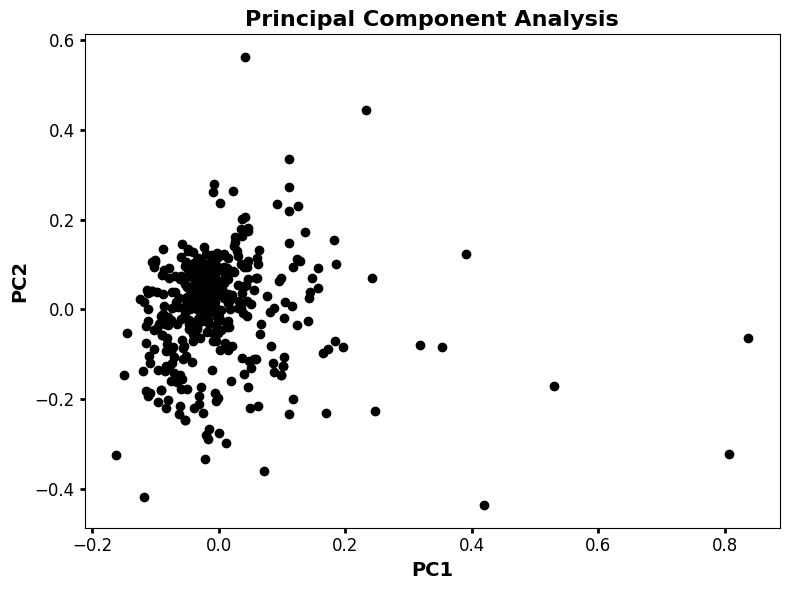

In [ ]:
#@title Gráfico de PCA normalizado
# Calculamos la escala para normalizar las componentes principales
scale1 = 1.0 / (max(descriptors_pca['PC1']) - min(descriptors_pca['PC1']))
scale2 = 1.0 / (max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))

# Normalizamos las componentes principales y las almacenamos en nuevas columnas
descriptors_pca['PC1_normalized'] = [i * scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized'] = [i * scale2 for i in descriptors_pca['PC2']]

# Crear una nueva figura con tamaño de 8x6 pulgadas
fig = plt.figure(figsize=(8, 6))

# Agregar un único subplot en la figura
ax = fig.add_subplot(111)

# Graficar las componentes principales normalizadas
ax.plot(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'], 'o', color='k')

# Establecer el título del gráfico
ax.set_title('Principal Component Analysis', fontsize=16, fontweight='bold', family='sans-serif')

# Etiquetar el eje x
ax.set_xlabel('PC1', fontsize=14, fontweight='bold')

# Etiquetar el eje y
ax.set_ylabel('PC2', fontsize=14, fontweight='bold')

# Configurar los parámetros de las marcas en los ejes
plt.tick_params('both', width=2, labelsize=12)

# Ajustar el diseño del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Para n_clusters = 2 El coeficiente de silueta promedio es: 0.47292901626703804
Para n_clusters = 3 El coeficiente de silueta promedio es: 0.43896059841228297
Para n_clusters = 4 El coeficiente de silueta promedio es: 0.4153962075176162
Para n_clusters = 5 El coeficiente de silueta promedio es: 0.4468510240720159
Para n_clusters = 6 El coeficiente de silueta promedio es: 0.35894032713443136
Para n_clusters = 7 El coeficiente de silueta promedio es: 0.37039038123106044
Para n_clusters = 8 El coeficiente de silueta promedio es: 0.3415677712243111
Para n_clusters = 9 El coeficiente de silueta promedio es: 0.34798560716766497
Para n_clusters = 10 El coeficiente de silueta promedio es: 0.36101308716781055


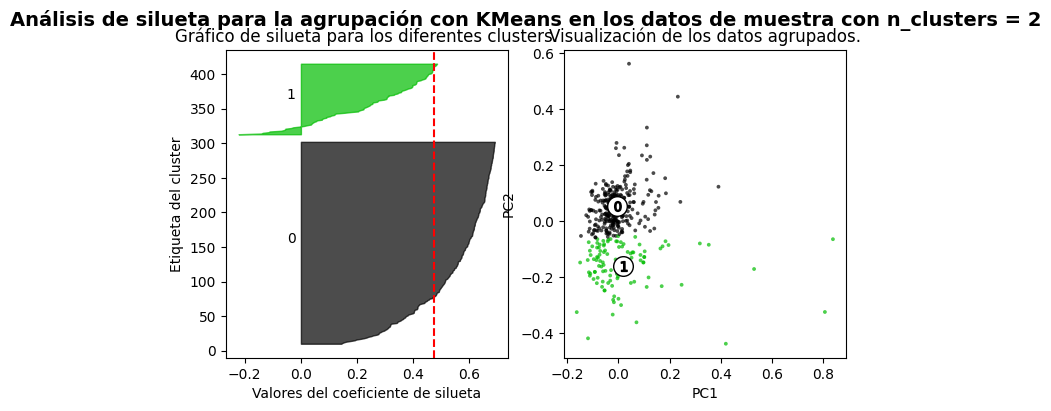

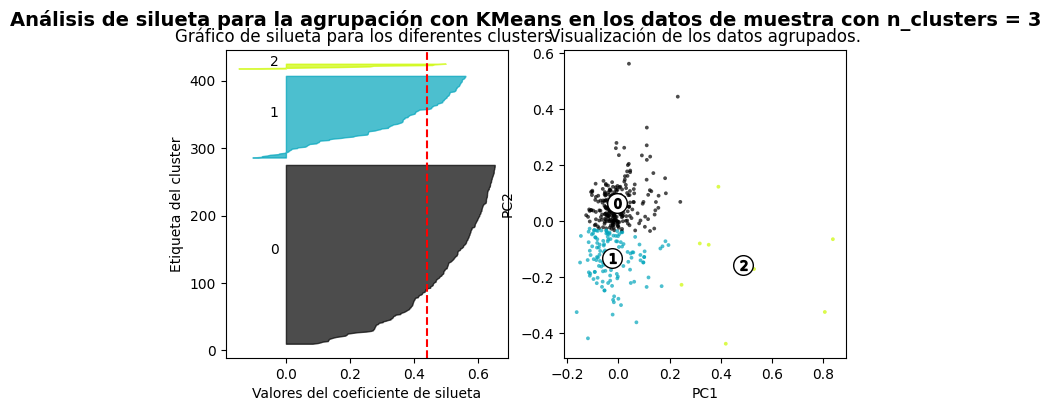

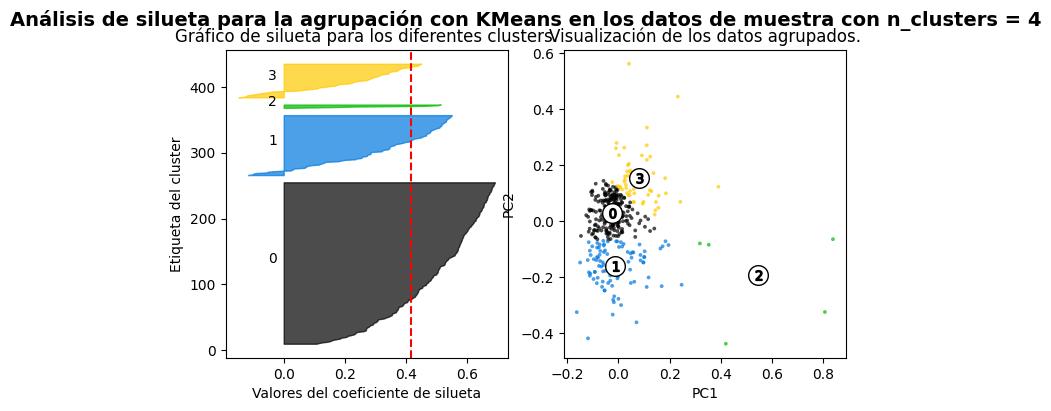

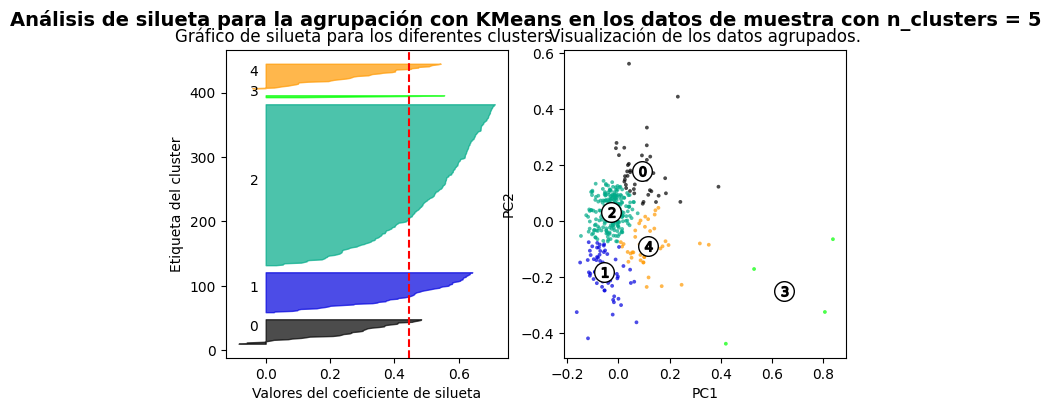

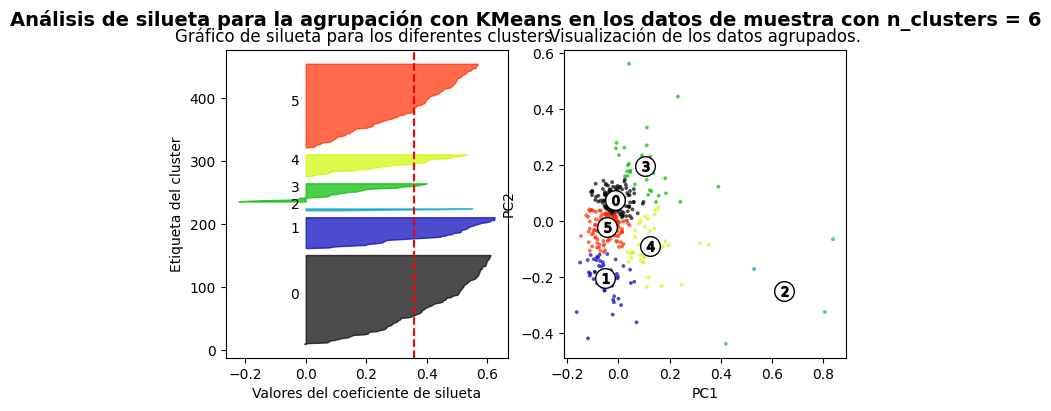

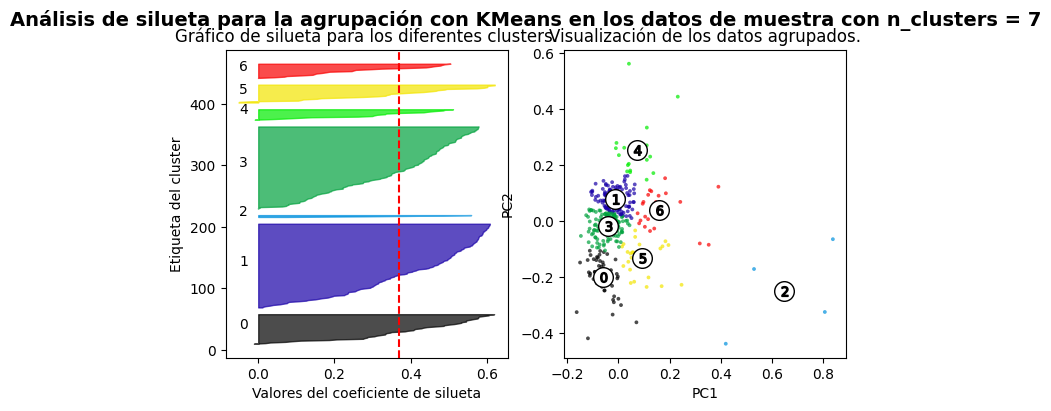

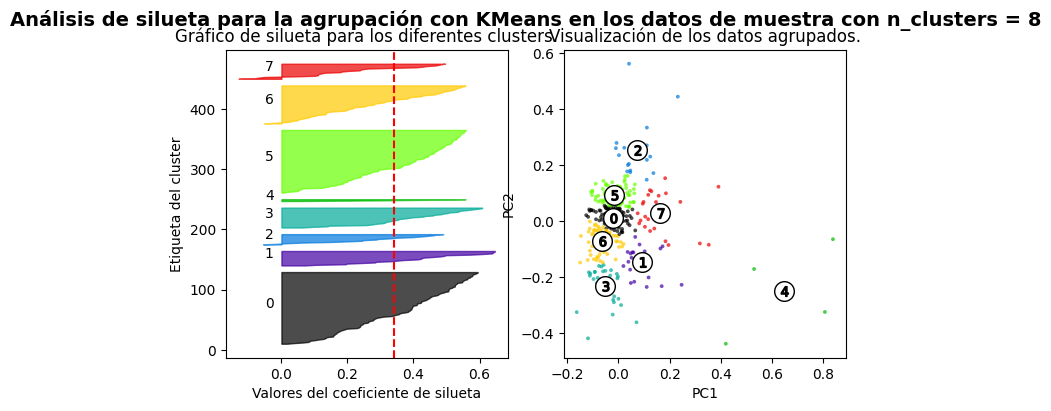

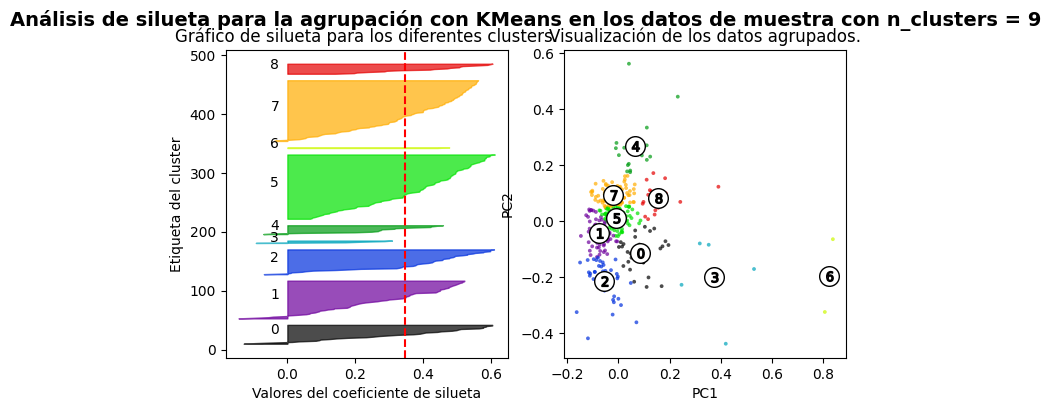

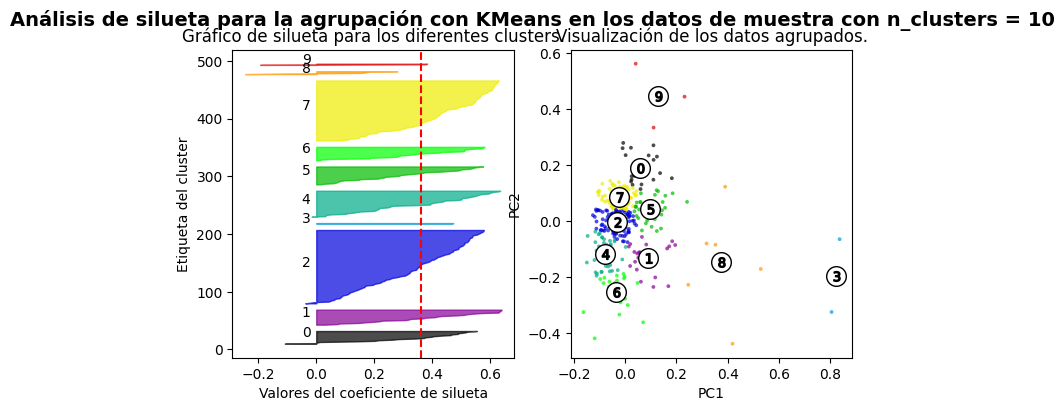

In [ ]:

#@title Evaluación del mejor número de clusters
# Realizamos el análisis de silueta para diferentes valores de K (número de clusters)
for n_clusters in range_K_clusters:
    warnings.filterwarnings('ignore', category=FutureWarning)
    # Creamos una figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)

    # Creamos una instancia del algoritmo KMeans con el número de clusters deseado
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)

    # Aplicamos el algoritmo a las componentes principales normalizadas
    cluster_labels = kmeans.fit_predict(descriptors_pca[['PC1_normalized', 'PC2_normalized']])

    # Calculamos el coeficiente de silueta promedio para evaluar la calidad de los clusters
    silhouette_avg = silhouette_score(descriptors_pca[['PC1_normalized', 'PC2_normalized']], cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El coeficiente de silueta promedio es:", silhouette_avg)

    # Calculamos los valores de silueta para cada muestra
    sample_silhouette_values = silhouette_samples(descriptors_pca[['PC1_normalized', 'PC2_normalized']], cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        # Agrupamos los valores de silueta para las muestras pertenecientes al cluster i y los ordenamos
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Definimos un color para el cluster i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Etiquetamos los gráficos de silueta con los números de cluster
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Calculamos el nuevo valor de y_lower para el próximo gráfico
        y_lower = y_upper + 10  # 10 para las muestras con valor 0

    # Configuramos el primer subplot (gráfico de silueta)
    ax1.set_title("Gráfico de silueta para los diferentes clusters.")
    ax1.set_xlabel("Valores del coeficiente de silueta")
    ax1.set_ylabel("Etiqueta del cluster")

    # Agregamos una línea vertical para el coeficiente de silueta promedio
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    # Configuramos el segundo subplot (visualización de los clusters)
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'],
                marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Etiquetamos los clusters
    centers = kmeans.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    # Iterar sobre los centroides de los clusters y graficarlos en el subplot ax2
    for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')
    # Configurar título y etiquetas de los ejes del subplot ax2
      ax2.set_title("Visualización de los datos agrupados.")
      ax2.set_xlabel("PC1")
      ax2.set_ylabel("PC2")

    # Configurar título principal de la figura con información del análisis de silueta
    plt.suptitle(("Análisis de silueta para la agrupación con KMeans en los datos de muestra con n_clusters = %d" % n_clusters),
                              fontsize=14, fontweight='bold')

# Mostrar la figura completa
plt.show()

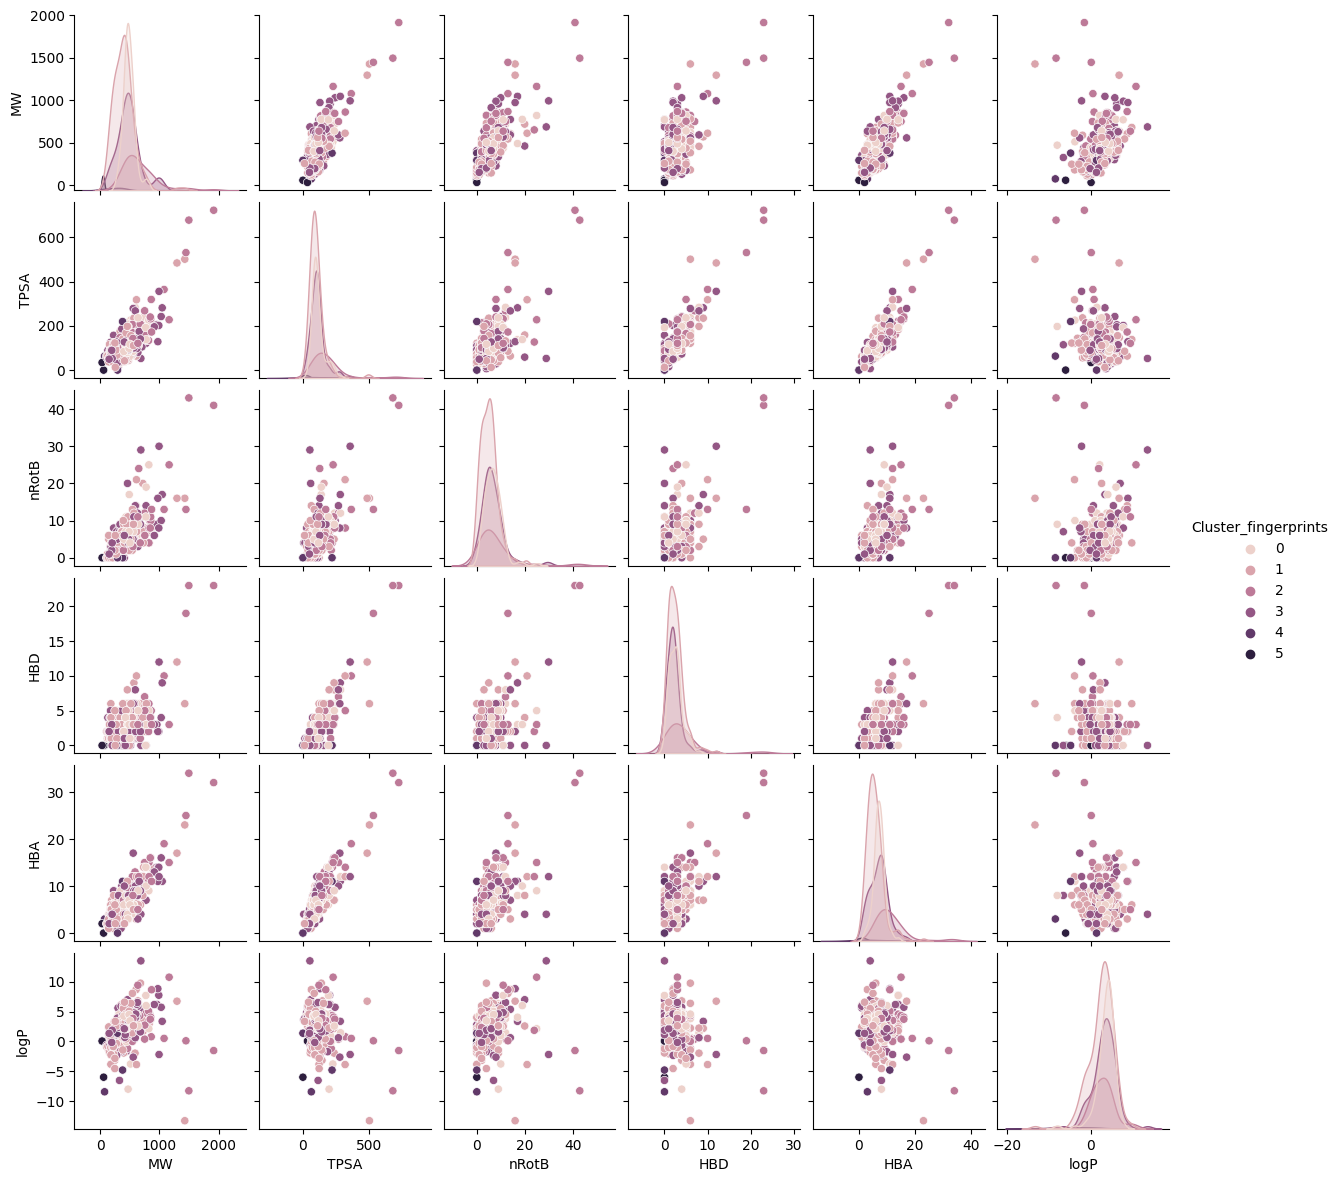

In [ ]:
sns.pairplot(tabla_lung_cancer_cortada.loc[:, ['MW', 'TPSA', 'nRotB', 'HBD','HBA', 'logP', "Cluster_fingerprints"]],hue="Cluster_fingerprints", height = 2)

# Bibliografía

Esta guía está elaborada en base a [Chemoinformatics Workflows](https://chem-workflows.com/).

1.  Gregory Landrum. Fingerprints in the RDKit (2012)
2.  Swamidass SJ, Baldi P. Bounds and algorithms for fast exact searches of chemical fingerprints in linear and sublinear time. J Chem Inf Model. 2007 Mar-Apr;47(2):302-17. doi: 10.1021/ci600358f. Epub 2007 Feb 28. PMID: 17326616; PMCID: PMC2527184.
3.  Virtanen, P., Gommers, R., Oliphant, T.E. et al. SciPy 1.0: fundamental algorithms for scientific computing in Python. Nat Methods 17, 261–272 (2020). https://doi.org/10.1038/s41592-019-0686-2
4.  Pedregosa F, Varoquaux G, Gramfort A, Michel V, Thirion B, Grisel O, Blondel M, Prettenhofer P, Weiss R, Dubourg V, Vanderplas J, Passos A, Cournapeau D, Brucher M, Perrot M, Duchesnay É. Scikit-learn: machine learning in python. The Journal of Machine Learning Research, 2011, 12: 2825–2830